In [1]:
# load packages and functions
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(cowplot))
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpointdensity))
suppressMessages(library(ggpubr))
suppressMessages(library(ggrepel))
suppressMessages(library(ggsci))
suppressMessages(library(ggthemes))
suppressMessages(library(gridExtra))
suppressMessages(library(ggpmisc))
suppressMessages(library(Hmisc))
suppressMessages(library(magrittr))
suppressMessages(library(patchwork))
suppressMessages(library(pROC))
suppressMessages(library(RColorBrewer))
suppressMessages(library(stringr))
suppressMessages(library(tidyverse))


# cluster annotation
cluster_df = read.table("/projects/jinamo@xsede.org/cytof/data/cluster_annotation.txt",sep="\t",header=TRUE) %>%
    dplyr::mutate(cluster = as.character(cluster))

In [2]:
# meta data
meta<- read.table("/projects/jinamo@xsede.org/cytof/data/RA_AtRiskRA_Control_meta.txt",sep="\t",header=TRUE, na.strings=c("","NA")) %>%
    dplyr::mutate(age_at_biopsy = as.integer(age_at_biopsy),
                  diagnosis = factor(diagnosis, levels=c("Control","AtRiskRA","RA")))
meta_add = read.table("/projects/jinamo@xsede.org/cytof/data/meta_clinical_RA.txt", header = TRUE, sep = "\t") %>%
  dplyr::mutate(CDAI = as.numeric(CDAI),
                subject_id = gsub("-","_",subject_id),
                treatment = dplyr::case_when(
                  treatment == "1" ~ "naive",
                  treatment == "2" ~ "MTX failure",
                  treatment == "3" ~ "TNF failure",
                  treatment == "4" ~ "OA"
                )) %>%
  dplyr::select(-c(sex,age))

meta_add2 = read.table("/projects/jinamo@xsede.org/cytof/data/clinical_data_for_FAN_from_Kat.txt", header = TRUE, sep = "\t") %>%
  dplyr::select(-c(sex))

meta_add3 = read.table("/projects/jinamo@xsede.org/cytof/data/RA_Cleaned_aggregate_vars.txt", header = TRUE, sep = "\t") %>%
  dplyr::select(c(subject_id,HAQ,das28_crp3,bmi,ra_group,pathotype_str,sdai,ccp_type,ccp_range,rf_range,mdtjc28_sum,mdsjc28_sum,criteria_2010_score,heart___1,lung___1,thyroid___1,ibd___1,psoriasis___1,comorb_none___1,alcohol,diabetes,MTX,SSZ,HCQ,LEF,TNFi,ra_group,pathotype_str))

meta_add4 = read.csv("/projects/jinamo@xsede.org/cytof/data/B_All_MD.csv", header = TRUE) %>%
    dplyr::mutate(subject_id = stringr::str_split(file, pattern="_", simplify=TRUE)[,3] %>% 
                                    stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
                                    as.data.frame() %>%
                                    .[,1] %>%
                                    gsub("-","_",.)) %>%
    dplyr::rename(time_point = Visit) %>%
    dplyr::select(c(time_point,subject_id,CDAI)) %>%
    tidyr::pivot_wider(names_from = time_point, values_from = CDAI) %>%
    .[,c("subject_id","V0","V1","V2")] %>%
    magrittr::set_colnames(c("subject_id","CDAI_V0","CDAI_V1","CDAI_V2")) %>%
    dplyr::arrange(subject_id)
meta_total = read.csv("/projects/jinamo@xsede.org/cytof/data/Total_Metadata.csv", header = TRUE) %>%
    dplyr::mutate(subject_id = gsub("-","_",Patient)) %>%
    dplyr::distinct(subject_id,.keep_all = TRUE)


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [3]:

# calculate proportion of each cluster in each major cell population

# set parameters
n_min = 10000
frac = 0.90

for (CELL in c("B_cells","NK_cells","T_cells","myeloid")){
  
  print(CELL)
  # parameter for UMAP
    if (CELL == "B_cells"){  
        prop = 1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.5
    } else if (CELL == "T_cells"){  
        prop = 0.1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.7
    } else if (CELL == "NK_cells"){  
        prop = 1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.3
    } else if (CELL == "myeloid"){    
        prop = 0.1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.3
    }
    
  umap_res <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/",CELL,"/umap_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
  # remove clusters less than cut off
  min_cell_cluster = 30
  clu = umap_res %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::arrange(count) %>%
    dplyr::filter(count > min_cell_cluster) %>%
    .$res_cell %>%
    unique()
  clu_logi = umap_res$res_cell %in% clu
  umap_res = umap_res[clu_logi,]
  
  if (CELL %in% c("B_cells","T_cells","myeloid")){
    batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/",CELL,"/meta_Prop",prop,"_Nmin",n_min,".rds"))
    batch_fl$subject_id <- stringr::str_split(batch_fl$OmiqFileIndex, pattern="_", simplify=TRUE)[,3] %>% 
      stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
      as.data.frame() %>%
      .[,1] %>%
      gsub("-","_",.)
    batch_fl = batch_fl[clu_logi,]
  } else if (CELL %in% c("NK_cells")){  
    batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/",CELL,"/meta_Prop",prop,"_Nmin",n_min,".rds"))
    batch_fl$subject_id <- stringr::str_split(batch_fl$OmiqFileIndex, pattern="_", simplify=TRUE)[,2] %>% 
      stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
      as.data.frame() %>%
      .[,1] %>%
      gsub("-","_",.)
    batch_fl = batch_fl[clu_logi,]
  }
  
  tmp = cbind(cluster = umap_res$res_cell,batch_fl) %>%
    dplyr::group_by(subject_id,time_point,cluster) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(subject_id,time_point) %>%
    dplyr::mutate(proportion = 100*count/sum(count),
                  subject_timepoint = paste(subject_id,time_point,sep="__")) %>%
    merge(.,
          batch_fl[,c("subject_id","disease")] %>%
            unique(),
          by = "subject_id") %>%
    dplyr::arrange(subject_id,cluster)
  for (ind in unique(tmp$subject_timepoint)){
    # print(paste0(grep(ind,unique(tmp$subject_id)),"/",length(unique(tmp$subject_id))))
    tmp_ind = tmp[tmp$subject_timepoint == ind,]
    for (clu in unique(umap_res$res_cell)[order(as.integer(unique(umap_res$res_cell)))]){
      # print(clu)
      if (nrow(tmp_ind[tmp_ind$cluster == clu,])==0){
        tmp = tmp %>% dplyr::add_row(subject_id = unique(tmp_ind$subject_id), subject_timepoint = ind, time_point = unique(tmp_ind$time_point), cluster = clu, count = 0, proportion = 0, disease = unique(tmp_ind$disease))
      }
    }
  }
  tmp = tmp %>% dplyr::arrange(subject_id,time_point,cluster) %>% dplyr::mutate(cluster = paste0(CELL,"_cluster",cluster), cell = ifelse(CELL %in% c("B_cells","NK_cells","T_cells"), gsub("_cells","",CELL),"M"))
  
  if (CELL == "B_cells"){
    df = tmp
  } else {
    df = rbind(tmp,df)
  }
  
}



[1] "B_cells"
       UMAP1      UMAP2 disease batch res_cell
1  0.7365184 -2.7977917 Control    15        0
2  2.4667720 -0.2356597 Control    15       12
3  0.1987944 -2.7129869 Control    15        0
4  0.1210516 -3.5780368 Control    15        0
5 -0.9618028  6.6663339 Control    15        7
6  3.5014135  0.1042377 Control    15       12
[1] 1918239       5
                  OmiqFileIndex disease Age Baseline batch CDAI CS CS_V0
1 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
2 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
3 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
4 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
5 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
6 Bcell_Control_200-0272-V0.fcs Control  28        0    15   NA  0    NA
  Cellcept DMARD Disease HCQ HCQ_V0 ISN.Class Longitudinal  Patient    Sex
1        0    NA Control   0     NA      <NA>      

`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


[1] "NK_cells"
       UMAP1     UMAP2 disease batch res_cell
1 -1.0852492 -5.609421 Control    15        1
2 -0.7627611 -4.311282 Control    15        1
3 -3.9263222  4.287653 Control    15        2
4 -3.3761160  3.396924 Control    15        0
5 12.2806943 -2.012380 Control    15        8
6  0.3788578 -8.128912 Control    15        6
[1] 2008702       5
            OmiqFileIndex disease                    file Age Baseline    Batch
1 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
2 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
3 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
4 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
5 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
6 Control_200-0272-V0.csv Control Control_200-0272-V0.fcs  28        0 Batch 15
  CDAI CS CS_V0 Cellcept DMARD Disease HCQ HCQ_V0 ISN.Class Longitudinal
1   NA  0 

`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


[1] "T_cells"
      UMAP1     UMAP2 disease batch res_cell
1 -9.449675 -2.127851 Control    15        8
2 -5.845147  1.816677 Control    15       12
3  6.496284  2.399950 Control    15        7
4  3.813404  3.555250 Control    15        5
5  2.793026  4.641660 Control    15        1
6  7.370950 -4.017954 Control    15        0
[1] 2196401       5
                   OmiqFileIndex disease Unfiltered.count batch Disease
1 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
2 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
3 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
4 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
5 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
6 T cell_Control_200-0272-V0.fcs Control            77817    15 Control
  condition time_point subject_id
1   Control         V0   200_0272
2   Control         V0   200_0272
3   Control         V0   200_0272
4   Control

`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


[1] "myeloid"
       UMAP1       UMAP2 disease batch res_cell
1  2.0532372   0.7853604 Control    15        0
2 -0.3599584  -1.2624608 Control    15        1
3 -4.5085528 -14.3289069 Control    15        5
4 -0.6125778   3.6431667 Control    15        0
5  1.3293630   2.2799052 Control    15        0
6 -0.2884055  -1.4845810 Control    15        1
[1] 1885837       5
                    OmiqFileIndex disease  sampleID patientID batch condition
1 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
2 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
3 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
4 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
5 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
6 Myeloid_Control_200-0272-V0.fcs Control CON0272V0   CON0272    15   Control
  time_point subject_id
1         V0   200_0272
2         V0   200_0272
3         V0

`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


In [5]:
## proportion of each major cell type
cell_prop = readRDS("/projects/jinamo@xsede.org/cytof/data/major_cell_type_abundance.rds") 
cell_prop %<>%
    dplyr::mutate(subject_timepoint = rownames(.),
                  subject_id = stringr::str_split(subject_timepoint,pattern="__",simplify=TRUE) %>% .[,1],
                  time_point = stringr::str_split(subject_timepoint,pattern="__",simplify=TRUE) %>% .[,2]) %>%
    dplyr::rename(B = `B cell/plasma cell`,
                  M = `Myeloid`,
                  T = `T cell`) %>%
    tidyr::pivot_longer(-c(subject_timepoint,subject_id,time_point)) %>%
    magrittr::set_colnames(c("subject_timepoint","subject_id","time_point","cell_type","prop")) %>%
    dplyr::mutate(prop = 100*prop)
head(cell_prop,30)
dim(cell_prop)

subject_timepoint subject_id time_point cell_type prop     
1  200_0272__V0      200_0272   V0         B          4.497198
2  200_0272__V0      200_0272   V0         M         43.488421
3  200_0272__V0      200_0272   V0         NK         3.053823
4  200_0272__V0      200_0272   V0         T         48.960558
5  200_0275__V0      200_0275   V0         B          8.397157
6  200_0275__V0      200_0275   V0         M         13.159292
7  200_0275__V0      200_0275   V0         NK         2.090155
8  200_0275__V0      200_0275   V0         T         76.353396
9  200_0276__V0      200_0276   V0         B          6.473128
10 200_0276__V0      200_0276   V0         M         15.604294
11 200_0276__V0      200_0276   V0         NK         2.106431
12 200_0276__V0      200_0276   V0         T         75.816146
13 200_0281__V0      200_0281   V0         B          7.160907
14 200_0281__V0      200_0281   V0         M         24.803458
15 200_0281__V0      200_0281   V0         NK         4.915885
16 200_0281__V0      200_0281   V0         T         63.119750
17 200_0282__V0      200_0282   V0         B          4.272626
18 200_0282__V0      200_0282   V0         M         10.635147
19 200_0282__V0      200_0282   V0         NK         1.688715
20 200_0282__V0      200_0282   V0         T         83.403512
21 200_0283__V0      200_0283   V0         B          5.867612
22 200_0283__V0      200_0283   V0         M         29.196769
23 200_0283__V0      200_0283   V0         NK         6.182187
24 200_0283__V0      200_0283   V0         T         58.753432
25 200_0285__V0      200_0285   V0         B          8.704989
26 200_0285__V0      200_0285   V0         M         17.032260
27 200_0285__V0      200_0285   V0         NK        10.075963
28 200_0285__V0      200_0285   V0         T         64.186788
29 200_0286__V0      200_0286   V0         B          5.754703
30 200_0286__V0      200_0286   V0         M         37.929126

[1] 772   5

In [6]:
# calculate correlation based on abundance per each cell type, not per all leukocytes
df %<>%
    dplyr::select(-c(subject_id,time_point)) %>%
    dplyr::left_join(.,cell_prop,by="subject_timepoint") %>%
    dplyr::filter(cell_type == cell) %>%
    # dplyr::mutate(proportion = proportion*prop/100) %>%
    dplyr::select(-c(cell,prop))

In [7]:
# transform to wide data frame
df_wide = df %>%
    dplyr::select(-c(count,cell_type)) %>%
    tidyr::pivot_wider(names_from = cluster, values_from = proportion) %>%
    dplyr::left_join(.,meta,by="subject_id") %>%
    dplyr::left_join(.,meta_add,by="subject_id") %>%
    dplyr::left_join(.,meta_add2,by="subject_id") %>%
    dplyr::left_join(.,meta_add3,by="subject_id") %>%
    dplyr::left_join(.,meta_add4,by="subject_id") %>%
    dplyr::mutate_at(vars(matches("^(B_cells|NK_cells|T_cells|myeloid)_cluster.*")), ~replace_na(.,0)) %>%
    dplyr::arrange(subject_timepoint)
df_wide$AtRisk = dplyr::case_when(
  df_wide$AMP_Group == "FDR" & df_wide$CCP == "Positive" ~ "FDR(+)/ACPA(+)",
  df_wide$AMP_Group == "GP" & df_wide$CCP == "Positive" ~ "FDR(-)/ACPA(+)",
  df_wide$AMP_Group == "FDR" & df_wide$CCP == "Negative" ~ "FDR(+)/ACPA(-)",
  df_wide$AMP_Group == "GP" & df_wide$CCP == "Negative" ~ "FDR(-)/ACPA(-)",
  df_wide$diagnosis == "Control" ~ "Control",
  df_wide$diagnosis == "RA" ~ "RA")
df_wide$AtRisk = factor(df_wide$AtRisk,levels=c("Control","FDR(-)/ACPA(-)","FDR(-)/ACPA(+)","FDR(+)/ACPA(-)","FDR(+)/ACPA(+)","RA"))
df_wide$diagnosis = ifelse(df_wide$AtRisk == "FDR(-)/ACPA(-)", "Control", as.character(df_wide$diagnosis))
df_wide$diagnosis = factor(df_wide$diagnosis, levels=c("Control","AtRiskRA","RA"))
df_wide$diagnosis_time = paste(df_wide$diagnosis,df_wide$time_point,sep="_") %>% factor(., levels=c("Control_V0","AtRiskRA_V0","RA_V0","RA_V1","RA_V2"))
df_wide$CCP_titer = ifelse(df_wide$AtRisk == "RA", df_wide$ccp_result, df_wide$CCP31_titer)
df_wide$RF_titer = ifelse(df_wide$AtRisk == "RA", df_wide$rf_result, df_wide$RF_IgM_titer)
head(df_wide)


subject_timepoint disease subject_id time_point myeloid_cluster0
1 200_0272__V0      Control 200_0272   V0         40.75408        
2 200_0275__V0      Control 200_0275   V0         37.17744        
3 200_0276__V0      Control 200_0276   V0         17.37000        
4 200_0281__V0      Control 200_0281   V0         37.50375        
5 200_0282__V0      Control 200_0282   V0         26.01723        
6 200_0283__V0      Control 200_0283   V0         33.40000        
  myeloid_cluster1 myeloid_cluster10 myeloid_cluster11 myeloid_cluster12
1 29.37294         1.160116          0.310031          2.820282         
2 21.69434         2.320464          0.930186          0.000000         
3 19.48000         3.880000          1.990000          0.000000         
4 29.14291         1.860186          0.790079          2.040204         
5 18.02518         4.347250          2.571239          0.000000         
6 23.06000         4.850000          0.680000          0.040000         
  myeloid_cluster13 ... HCQ LEF TNFi CDAI_V0 CDAI_V1 CDAI_V2 AtRisk 
1 0.360036          ... NA  NA  NA   NA      NA      NA      Control
2 0.110022          ... NA  NA  NA   NA      NA      NA      Control
3 0.090000          ... NA  NA  NA   NA      NA      NA      Control
4 0.180018          ... NA  NA  NA   NA      NA      NA      Control
5 0.490391          ... NA  NA  NA   NA      NA      NA      Control
6 0.190000          ... NA  NA  NA   NA      NA      NA      Control
  diagnosis_time CCP_titer RF_titer
1 Control_V0     NA        NA      
2 Control_V0     NA        NA      
3 Control_V0     NA        NA      
4 Control_V0     NA        NA      
5 Control_V0     NA        NA      
6 Control_V0     NA        NA

[1] 192 168

[1] "subject_timepoint"       "disease"                
  [3] "subject_id"              "time_point"             
  [5] "myeloid_cluster0"        "myeloid_cluster1"       
  [7] "myeloid_cluster10"       "myeloid_cluster11"      
  [9] "myeloid_cluster12"       "myeloid_cluster13"      
 [11] "myeloid_cluster14"       "myeloid_cluster15"      
 [13] "myeloid_cluster2"        "myeloid_cluster3"       
 [15] "myeloid_cluster4"        "myeloid_cluster5"       
 [17] "myeloid_cluster6"        "myeloid_cluster7"       
 [19] "myeloid_cluster8"        "myeloid_cluster9"       
 [21] "T_cells_cluster0"        "T_cells_cluster1"       
 [23] "T_cells_cluster10"       "T_cells_cluster11"      
 [25] "T_cells_cluster12"       "T_cells_cluster13"      
 [27] "T_cells_cluster14"       "T_cells_cluster15"      
 [29] "T_cells_cluster16"       "T_cells_cluster17"      
 [31] "T_cells_cluster18"       "T_cells_cluster19"      
 [33] "T_cells_cluster2"        "T_cells_cluster20"      
 [35] "T_cells_cluster21"       "T_cells_cluster22"      
 [37] "T_cells_cluster23"       "T_cells_cluster24"      
 [39] "T_cells_cluster25"       "T_cells_cluster3"       
 [41] "T_cells_cluster4"        "T_cells_cluster5"       
 [43] "T_cells_cluster6"        "T_cells_cluster7"       
 [45] "T_cells_cluster8"        "T_cells_cluster9"       
 [47] "NK_cells_cluster0"       "NK_cells_cluster1"      
 [49] "NK_cells_cluster10"      "NK_cells_cluster11"     
 [51] "NK_cells_cluster12"      "NK_cells_cluster13"     
 [53] "NK_cells_cluster14"      "NK_cells_cluster15"     
 [55] "NK_cells_cluster16"      "NK_cells_cluster2"      
 [57] "NK_cells_cluster3"       "NK_cells_cluster4"      
 [59] "NK_cells_cluster5"       "NK_cells_cluster6"      
 [61] "NK_cells_cluster7"       "NK_cells_cluster8"      
 [63] "NK_cells_cluster9"       "B_cells_cluster0"       
 [65] "B_cells_cluster1"        "B_cells_cluster10"      
 [67] "B_cells_cluster11"       "B_cells_cluster12"      
 [69] "B_cells_cluster13"       "B_cells_cluster14"      
 [71] "B_cells_cluster15"       "B_cells_cluster16"      
 [73] "B_cells_cluster17"       "B_cells_cluster18"      
 [75] "B_cells_cluster19"       "B_cells_cluster2"       
 [77] "B_cells_cluster3"        "B_cells_cluster4"       
 [79] "B_cells_cluster5"        "B_cells_cluster6"       
 [81] "B_cells_cluster7"        "B_cells_cluster8"       
 [83] "B_cells_cluster9"        "age_at_biopsy"          
 [85] "sex"                     "ethnicity"              
 [87] "diagnosis"               "collection_method"      
 [89] "ctap"                    "AMP_Group"              
 [91] "CCP"                     "RF"                     
 [93] "CCP30_titer"             "CCP31_titer"            
 [95] "RF_IgM_titer"            "RF_IgG_titer"           
 [97] "RF_IgA_titer"            "pipeline_date"          
 [99] "site"                    "treatment"              
[101] "biopsied"                "CDAI"                   
[103] "disease_duration"        "tissue_type"            
[105] "krenn_lining"            "krenn_inflammation"     
[107] "single_cell_tech"        "cell_count_to_10x"      
[109] "mRNA_run"                "protein_run"            
[111] "atac_run"                "qc"                     
[113] "age"                     "RA_duration_years"      
[115] "Race_white"              "Race_black"             
[117] "Race_other"              "ethnicity_hisp"         
[119] "esr_result"              "crp_result"             
[121] "cdai"                    "das28_esr3"             
[123] "ccp_result"              "rf_result"              
[125] "smoke_hx"                "smoke_current"          
[127] "grp_final_dfg"           "Methotrexate_only"      
[129] "TNFi_possible_nbDMARD"   "other_bDMARD"           
[131] "other_nbDMARD_no_bDMARD" "no_DMARD"               
[133] "bDMARD"                  "nbDMARD"                
[135] "Prednisone"              "Prednisone_GE_7.5"      
[137] "HAQ"                     "das28_crp3"             



 V0  V1  V2 
152  21  19 


 Control AtRiskRA       RA 
      46       49       97 


200_0272 200_0275 200_0276 200_0281 200_0282 200_0283 200_0285 200_0286 
       1        1        1        1        1        1        1        1 
200_0288 200_0295 200_0296 200_0298 200_0299 200_0300 200_1519 200_1520 
       1        1        1        1        1        1        1        1 
200_1522 200_1523 200_1524 200_1529 200_1533 200_1534 200_1535 200_2083 
       1        1        1        1        1        1        1        1 
200_2097 200_2099 200_2104 200_2107 200_2109 200_2110 200_2113 200_2115 
       1        1        1        1        1        1        1        1 
200_2121 200_2122 200_2126 200_2127 200_2128 200_2129 200_2853 300_0143 
       1        1        1        1        1        1        1        2 
300_0144 300_0145 300_0149 300_0150 300_0151 300_0171 300_0172 300_0173 
       2        2        3        3        1        2        1        1 
300_0174 300_0175 300_0176 300_0183 300_0221 300_0223 300_0226 300_0228 
       1        2        1        1        2      


       Control FDR(-)/ACPA(-) FDR(-)/ACPA(+) FDR(+)/ACPA(-) FDR(+)/ACPA(+) 
            39              7              8             21             20 
            RA 
            97 


E + F + M         F         M     T + B     T + F     T + M 
       12        10        23        19        10        20 


MTX failure TNF failure       naive 
         39          23          35 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     9.5    92.0   131.2   250.0  1119.0      41 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    0.25   14.40  137.32  160.00 1450.00      45 

In [8]:
# log scaling
prop_mat = df_wide %>% 
    dplyr::mutate(across(contains("_cluster"), ~ .x + 1)) %>%
    .[,grepl("cluster",colnames(df_wide))] %>%
    log()
head(prop_mat)
dim(prop_mat)

myeloid_cluster0 myeloid_cluster1 myeloid_cluster10 myeloid_cluster11
1 3.731797         3.413552         0.7701619         0.2700508        
2 3.642245         3.122116         1.2001046         0.6576164        
3 2.910719         3.019449         1.5851452         1.0952734        
4 3.650756         3.405950         1.0508867         0.5822598        
5 3.296475         2.945763         1.6765824         1.2729127        
6 3.538057         3.180551         1.7664417         0.5187938        
  myeloid_cluster12 myeloid_cluster13 myeloid_cluster14 myeloid_cluster15
1 1.34032425        0.3075112         0                 0.14843380       
2 0.00000000        0.1043798         0                 0.13978803       
3 0.00000000        0.0861777         0                 0.08617770       
4 1.11192463        0.1655297         0                 0.09531927       
5 0.00000000        0.3990385         0                 0.18132703       
6 0.03922071        0.1739533         0                 0.05826891       
  myeloid_cluster2 myeloid_cluster3 ... B_cells_cluster18 B_cells_cluster19
1 1.796830         0.2926950        ... 0.00000000        0.00000000       
2 2.392608         2.6750243        ... 0.00000000        0.00000000       
3 1.906575         3.4323730        ... 0.00000000        0.00000000       
4 2.411531         0.1570183        ... 0.00000000        0.00000000       
5 2.655163         2.4246444        ... 0.00000000        0.00000000       
6 2.803360         1.6863990        ... 0.01271958        0.01271958       
  B_cells_cluster2 B_cells_cluster3 B_cells_cluster4 B_cells_cluster5
1 2.769869         2.931826         2.245635         2.040323        
2 2.873586         2.219535         2.144869         1.650941        
3 2.650545         2.796524         2.307588         2.131460        
4 2.324236         2.925451         1.657107         2.902717        
5 2.517979         3.183054         1.611441         2.656156        
6 2.653076         2.875296         2.082892         1.705818        
  B_cells_cluster6 B_cells_cluster7 B_cells_cluster8 B_cells_cluster9
1 1.739736         1.2441225        1.1228127        0.7624246       
2 2.549350         1.2452464        1.5871949        0.6278850       
3 1.648007         1.6008066        1.0862216        0.9067079       
4 2.209611         2.3136656        0.8329512        1.0314367       
5 1.533439         2.3713440        1.0430743        1.8246301       
6 1.742342         0.8129195        1.3978758        0.5842531

[1] 192  79

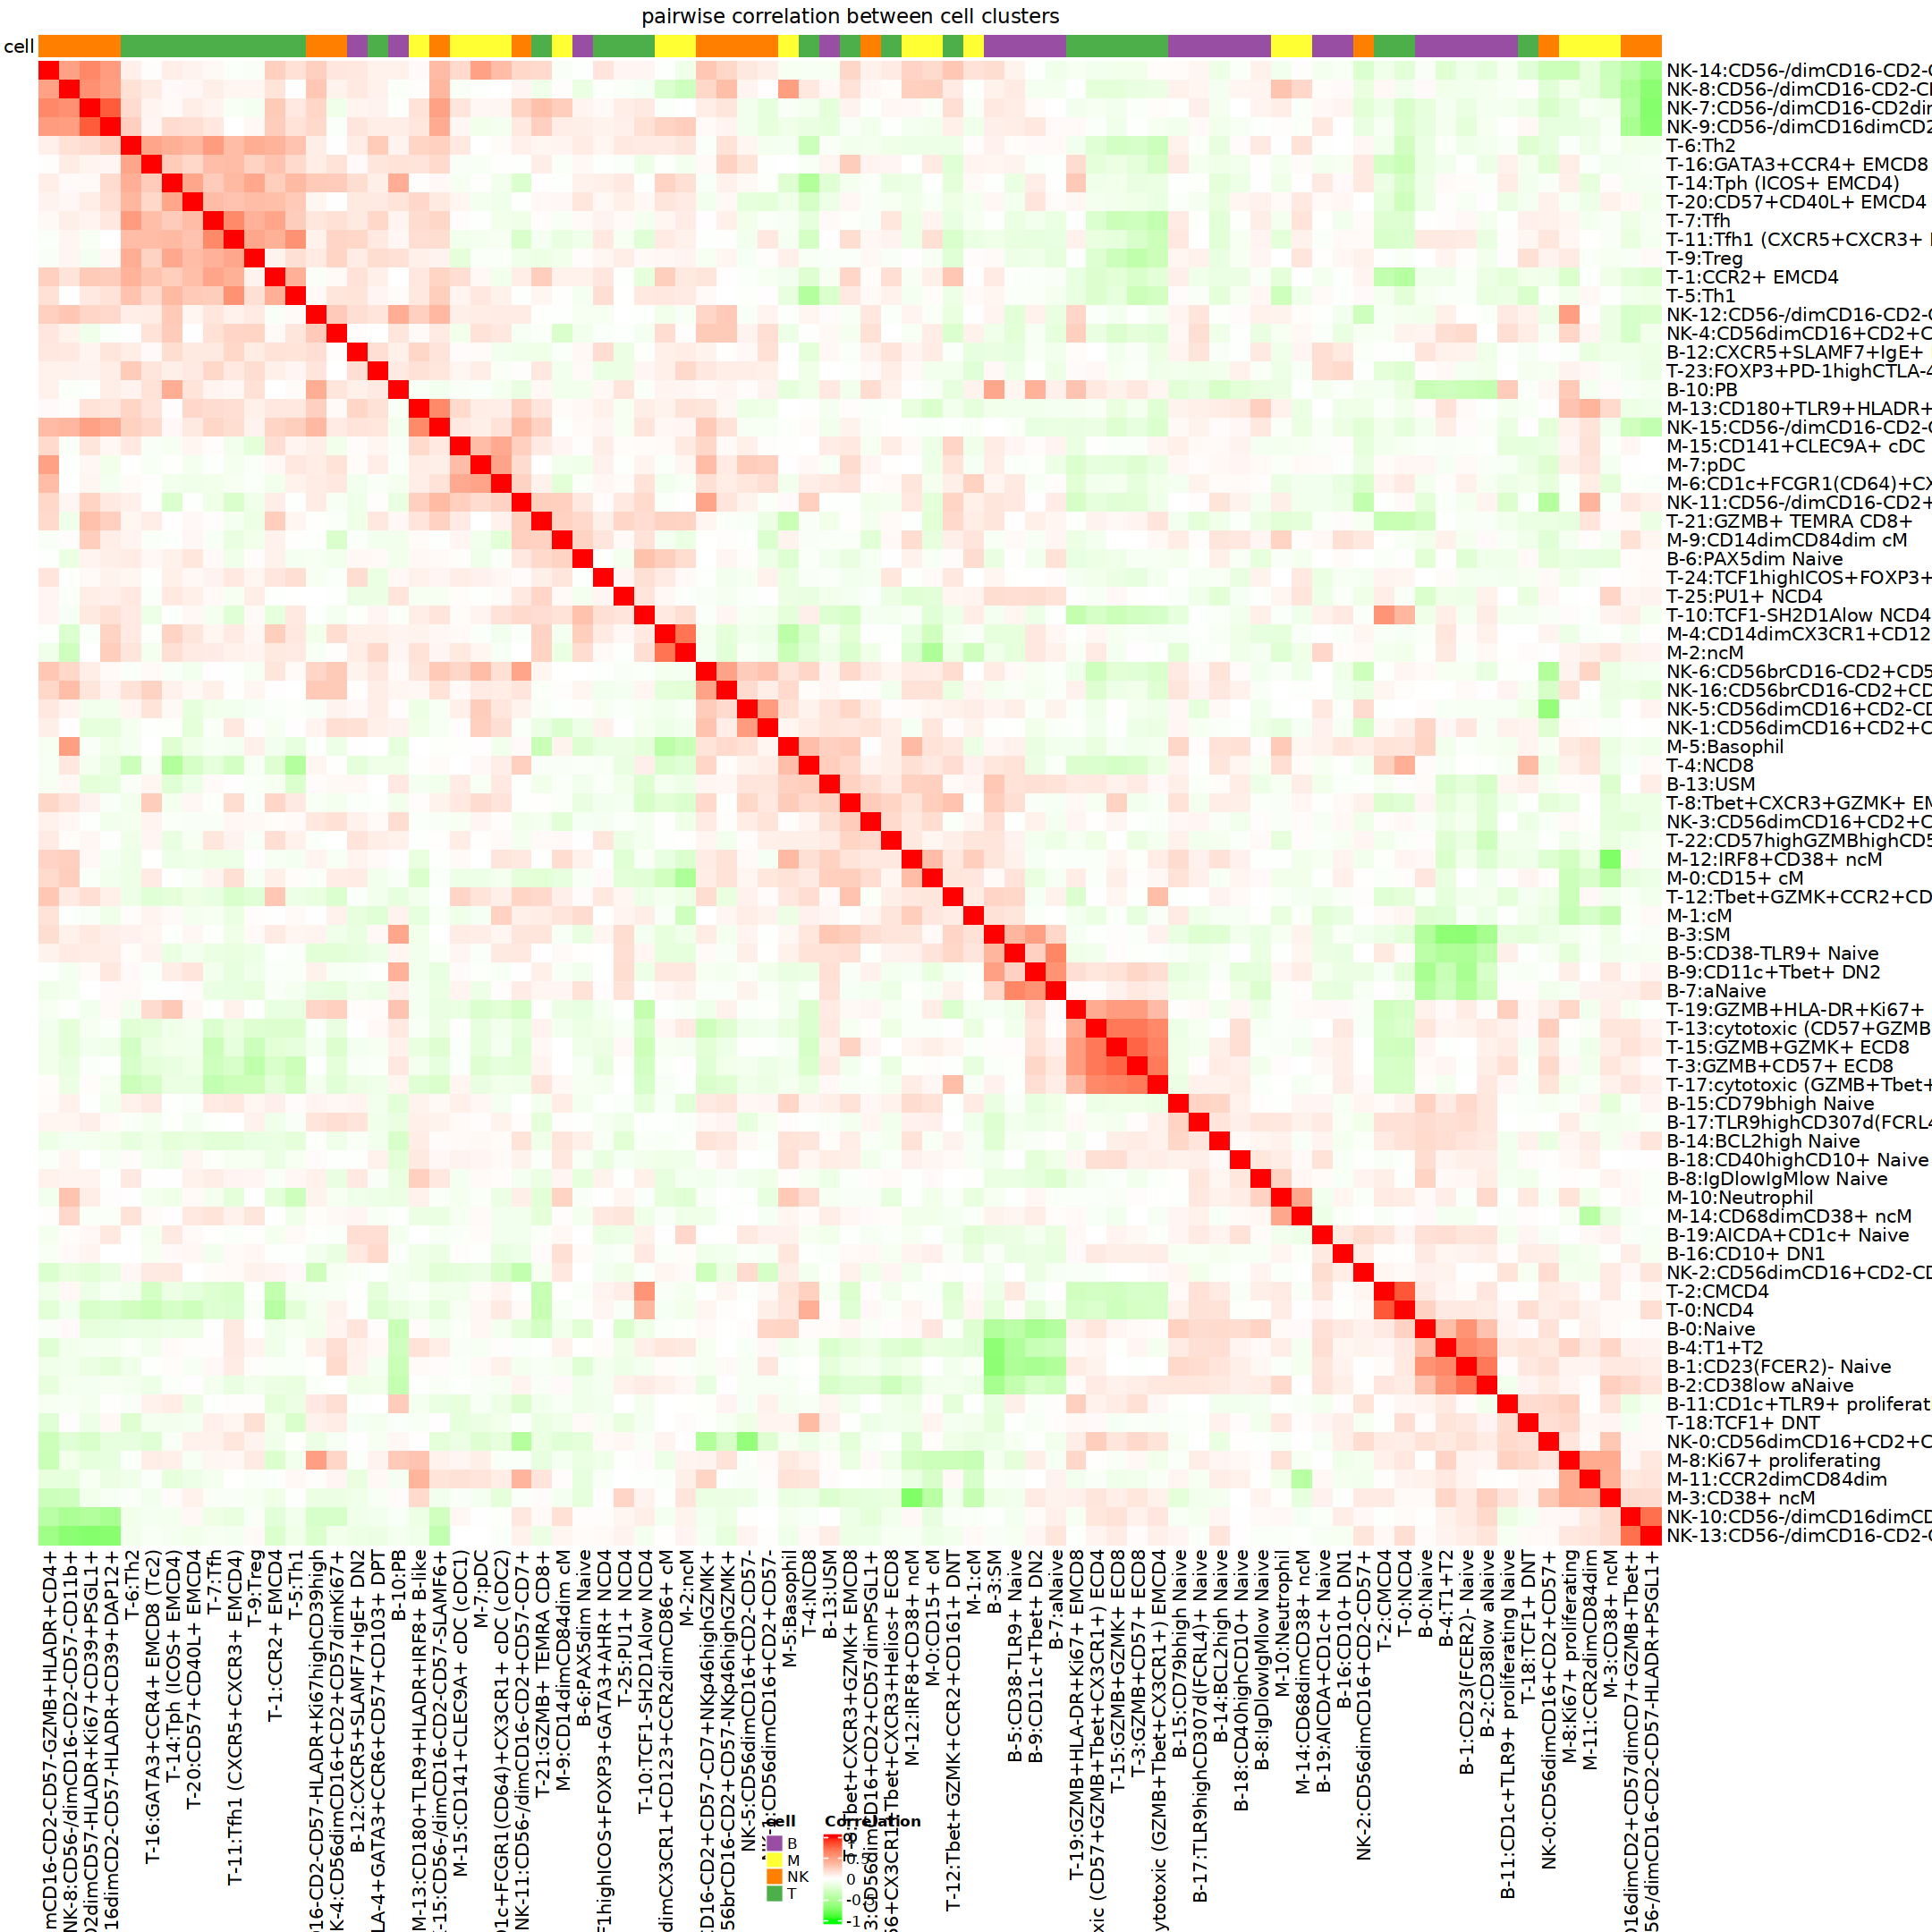

[1] "M-0:CD15+ cM"                                            
 [2] "M-1:cM"                                                  
 [3] "M-10:Neutrophil"                                         
 [4] "M-11:CCR2dimCD84dim"                                     
 [5] "M-12:IRF8+CD38+ ncM"                                     
 [6] "M-13:CD180+TLR9+HLADR+IRF8+ B-like"                      
 [7] "M-14:CD68dimCD38+ ncM"                                   
 [8] "M-15:CD141+CLEC9A+ cDC (cDC1)"                           
 [9] "M-2:ncM"                                                 
[10] "M-3:CD38+ ncM"                                           
[11] "M-4:CD14dimCX3CR1+CD123+CCR2dimCD86+ cM"                 
[12] "M-5:Basophil"                                            
[13] "M-6:CD1c+FCGR1(CD64)+CX3CR1+ cDC (cDC2)"                 
[14] "M-7:pDC"                                                 
[15] "M-8:Ki67+ proliferating"                                 
[16] "M-9:CD14dimCD84dim cM"                                   
[17] "T-0:NCD4"                                                
[18] "T-1:CCR2+ EMCD4"                                         
[19] "T-10:TCF1-SH2D1Alow NCD4"                                
[20] "T-11:Tfh1 (CXCR5+CXCR3+ EMCD4)"                          
[21] "T-12:Tbet+GZMK+CCR2+CD161+ DNT"                          
[22] "T-13:cytotoxic (CD57+GZMB+Tbet+CX3CR1+) ECD4"            
[23] "T-14:Tph (ICOS+ EMCD4)"                                  
[24] "T-15:GZMB+GZMK+ ECD8"                                    
[25] "T-16:GATA3+CCR4+ EMCD8 (Tc2)"                            
[26] "T-17:cytotoxic (GZMB+Tbet+CX3CR1+) EMCD4"                
[27] "T-18:TCF1+ DNT"                                          
[28] "T-19:GZMB+HLA-DR+Ki67+ EMCD8"                            
[29] "T-2:CMCD4"                                               
[30] "T-20:CD57+CD40L+ EMCD4"                                  
[31] "T-21:GZMB+ TEMRA CD8+"                                   
[32] "T-22:CD57highGZMBhighCD56+CX3CR1+Tbet+CXCR3+Helios+ ECD8"
[33] "T-23:FOXP3+PD-1highCTLA-4+GATA3+CCR6+CD57+CD103+ DPT"    
[34] "T-24:TCF1highICOS+FOXP3+GATA3+AHR+ NCD4"                 
[35] "T-25:PU1+ NCD4"                                          
[36] "T-3:GZMB+CD57+ ECD8"                                     
[37] "T-4:NCD8"                                                
[38] "T-5:Th1"                                                 
[39] "T-6:Th2"                                                 
[40] "T-7:Tfh"                                                 
[41] "T-8:Tbet+CXCR3+GZMK+ EMCD8"                              
[42] "T-9:Treg"                                                
[43] "NK-0:CD56dimCD16+CD2+CD57+"                              
[44] "NK-1:CD56dimCD16+CD2+CD57-"                              
[45] "NK-10:CD56-/dimCD16dimCD2+CD57dimCD7+GZMB+Tbet+"         
[46] "NK-11:CD56-/dimCD16-CD2+CD57-CD7+"                       
[47] "NK-12:CD56-/dimCD16-CD2-CD57-HLADR+Ki67highCD39high"     
[48] "NK-13:CD56-/dimCD16-CD2-CD57-HLADR+PSGL1+"               
[49] "NK-14:CD56-/dimCD16-CD2-CD57-GZMB+HLADR+CD4+"            
[50] "NK-15:CD56-/dimCD16-CD2-CD57-SLAMF6+"                    
[51] "NK-16:CD56brCD16-CD2+CD57-NKp46highGZMK+"                
[52] "NK-2:CD56dimCD16+CD2-CD57+"                              
[53] "NK-3:CD56dimCD16+CD2+CD57dimPSGL1+"                      
[54] "NK-4:CD56dimCD16+CD2+CD57dimKi67+"                       
[55] "NK-5:CD56dimCD16+CD2-CD57-"                              
[56] "NK-6:CD56brCD16-CD2+CD57-CD7+NKp46highGZMK+"             
[57] "NK-7:CD56-/dimCD16-CD2dimCD57-HLADR+Ki67+CD39+PSGL1+"    
[58] "NK-8:CD56-/dimCD16-CD2-CD57-CD11b+"                      
[59] "NK-9:CD56-/dimCD16dimCD2-CD57-HLADR+CD39+DAP12+"         
[60] "B-0:Naive"                                               
[61] "B-1:CD23(FCER2)- Naive"                                  
[62] "B-10:PB"                                                 
[63] "B-11:CD1c+TLR9+ proliferati

Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”
`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


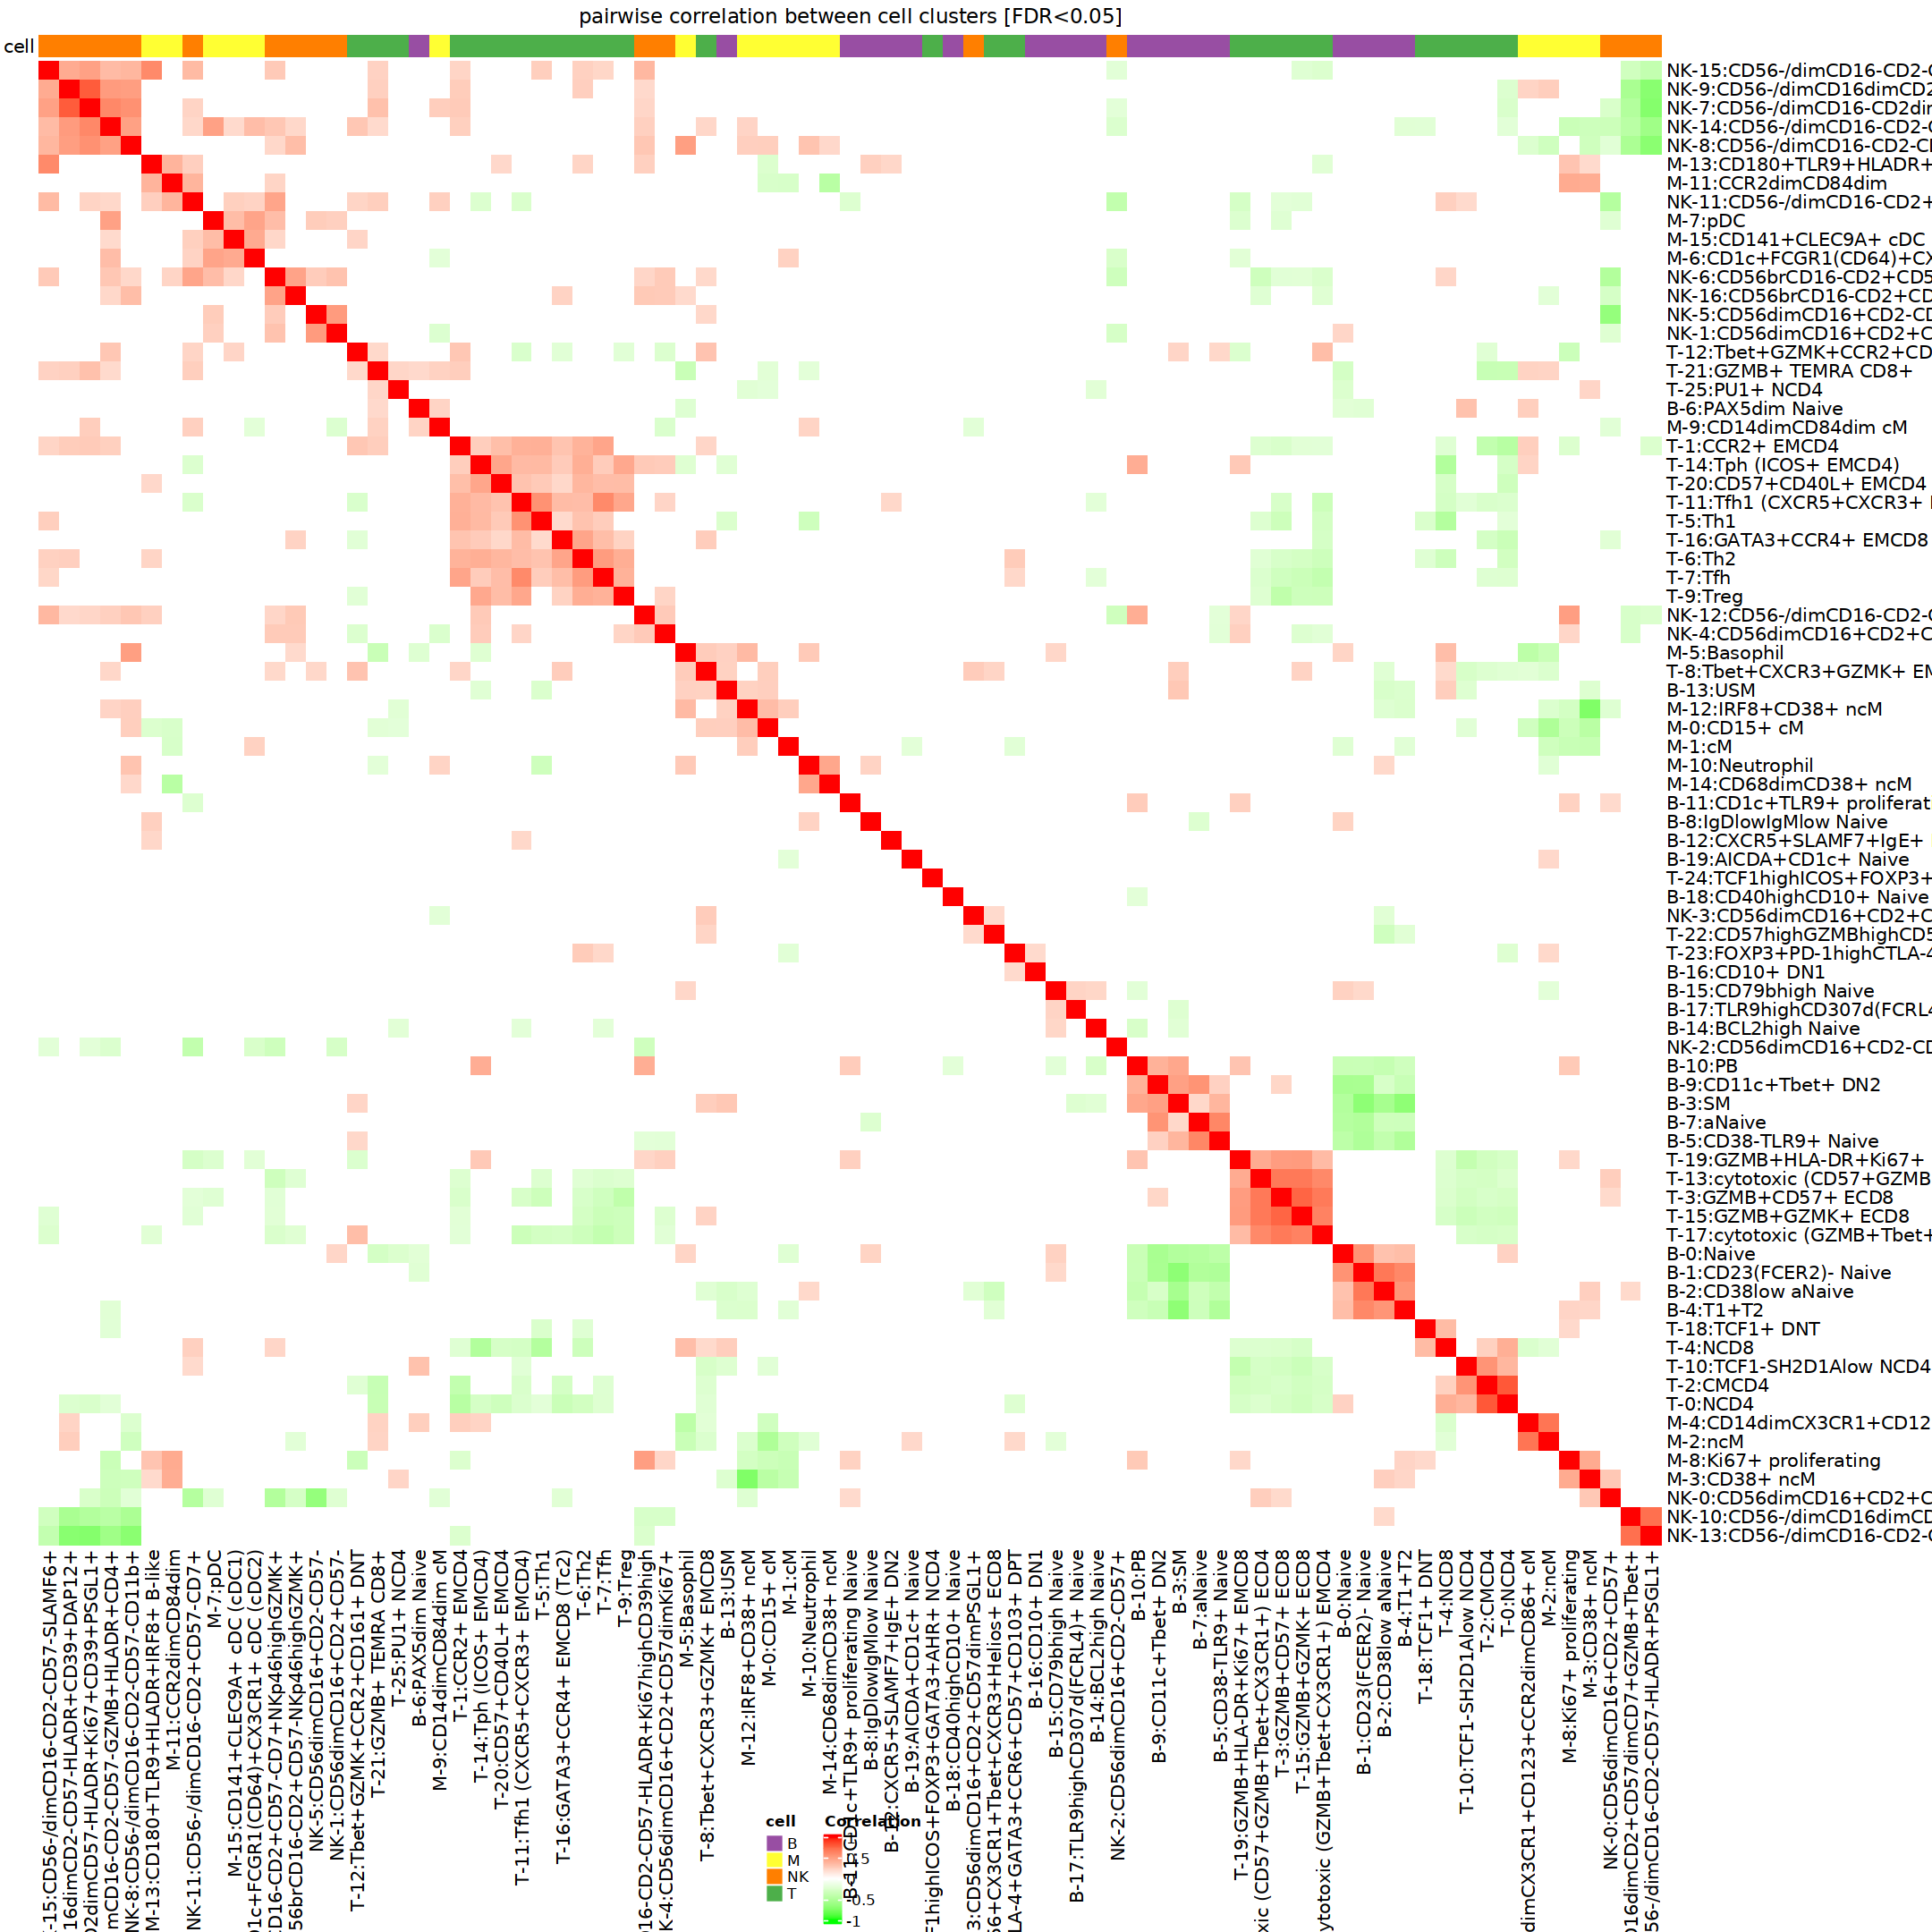

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


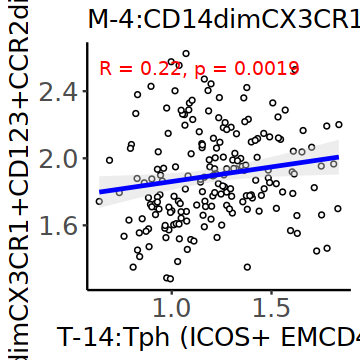

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


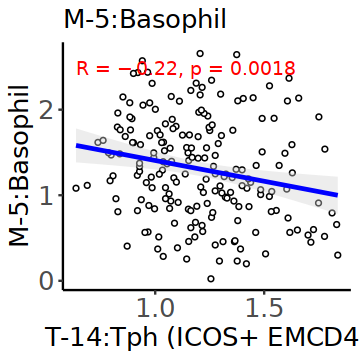

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


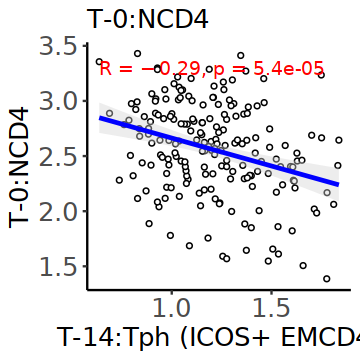

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


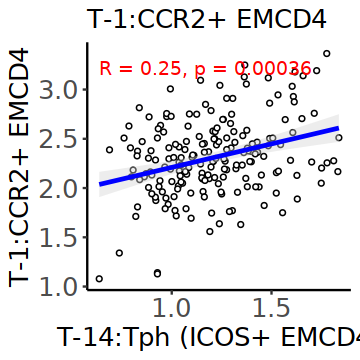

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


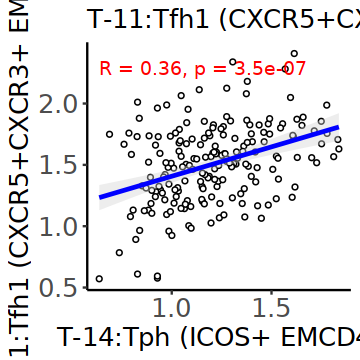

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


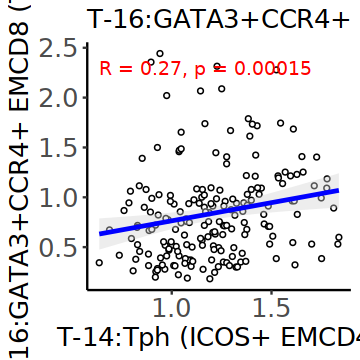

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


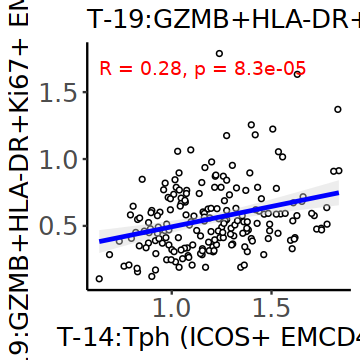

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


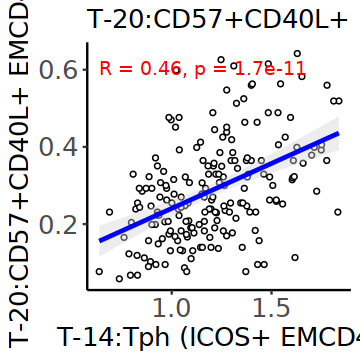

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


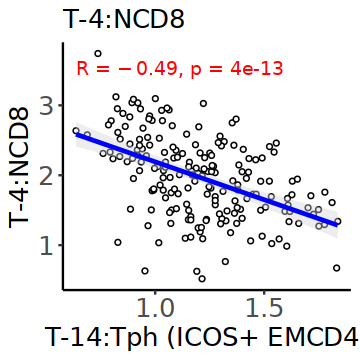

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


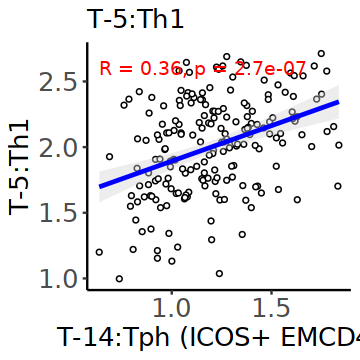

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


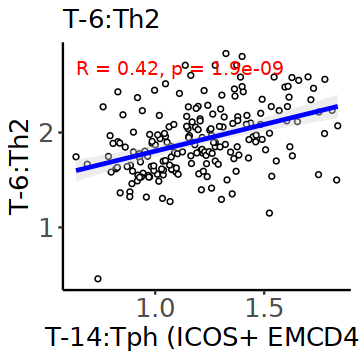

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


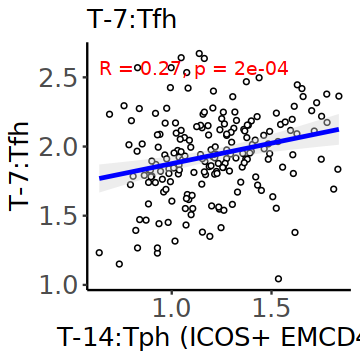

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


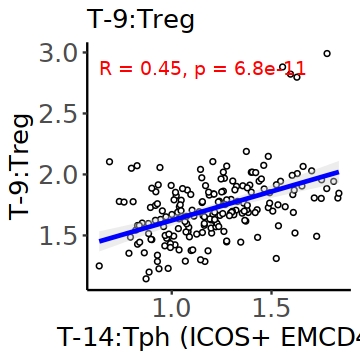

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


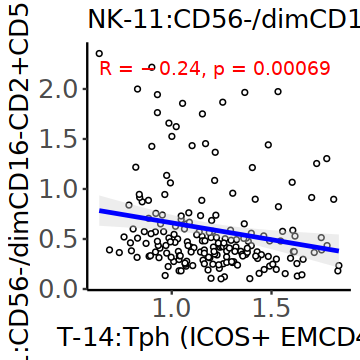

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


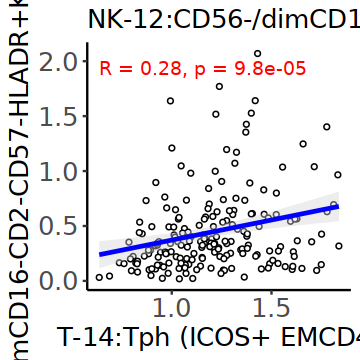

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


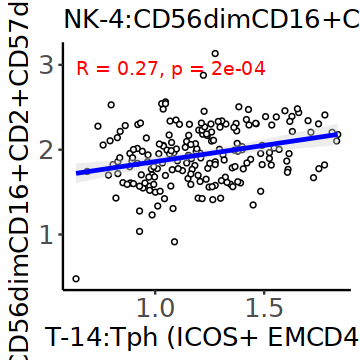

`geom_smooth()` using formula = 'y ~ x'


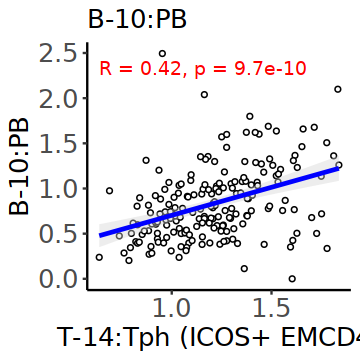

Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”
`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


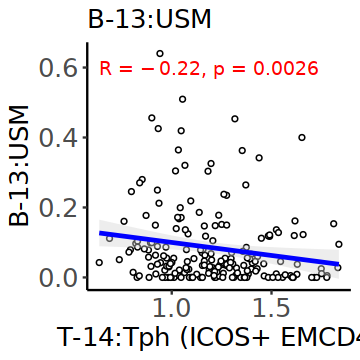

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


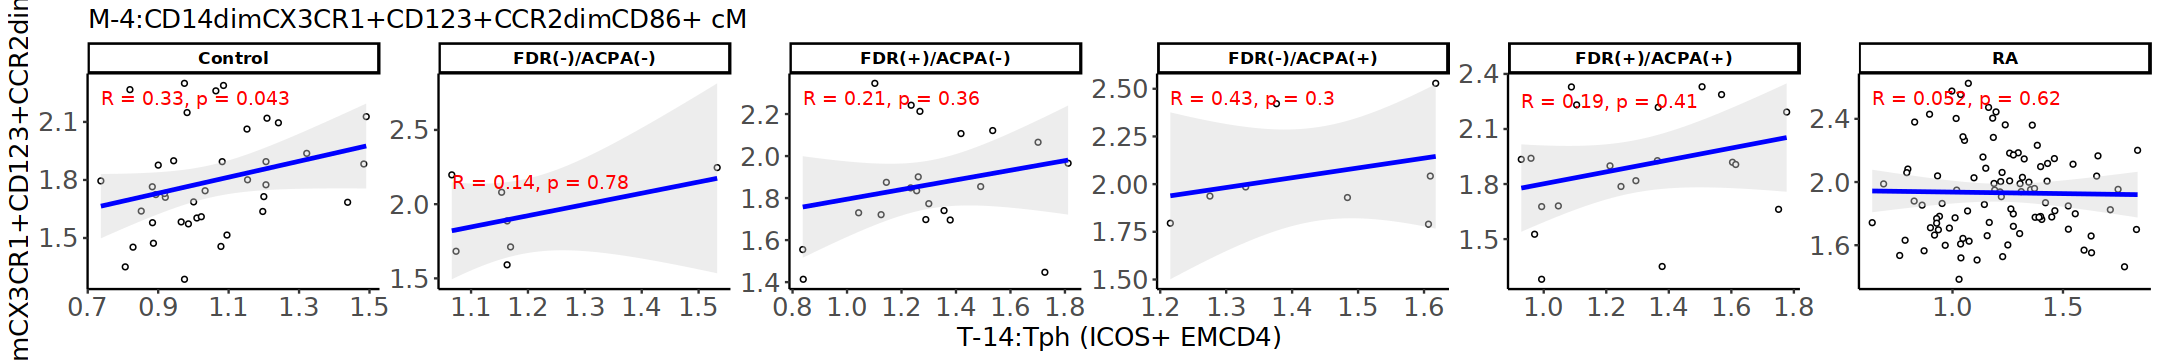

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


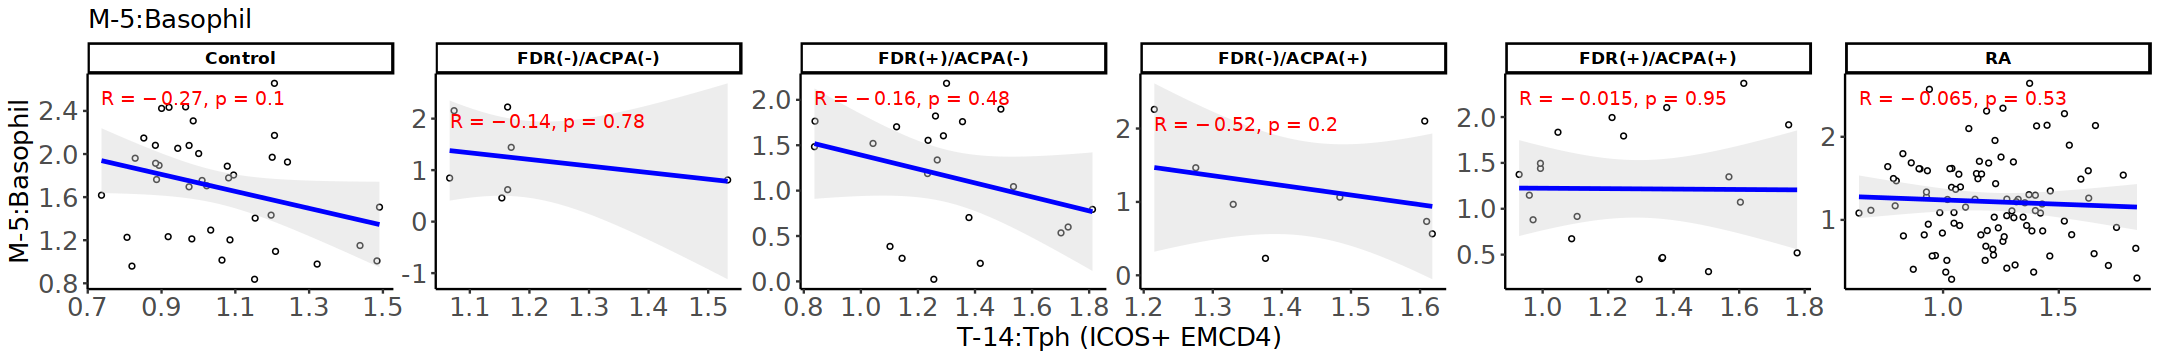

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


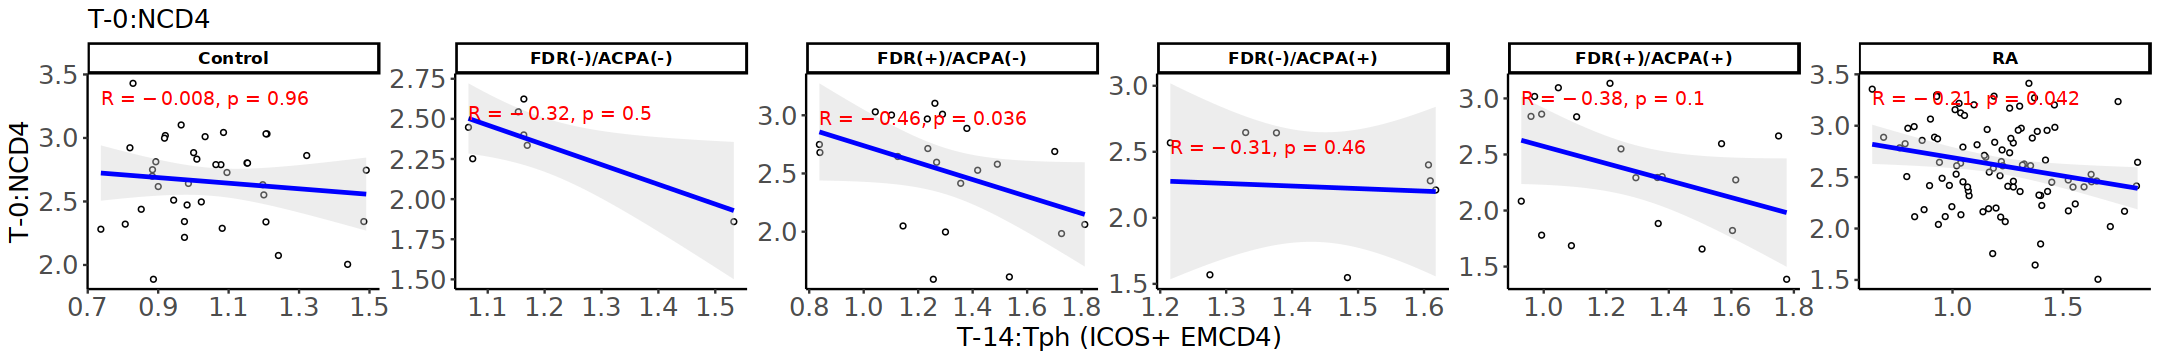

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


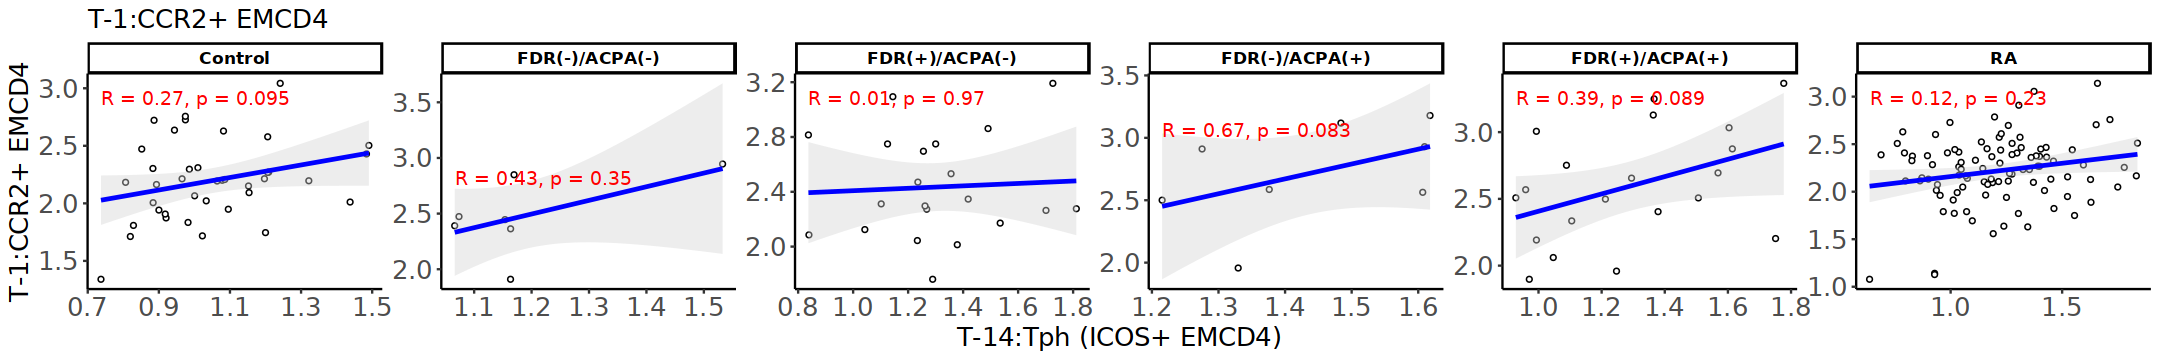

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


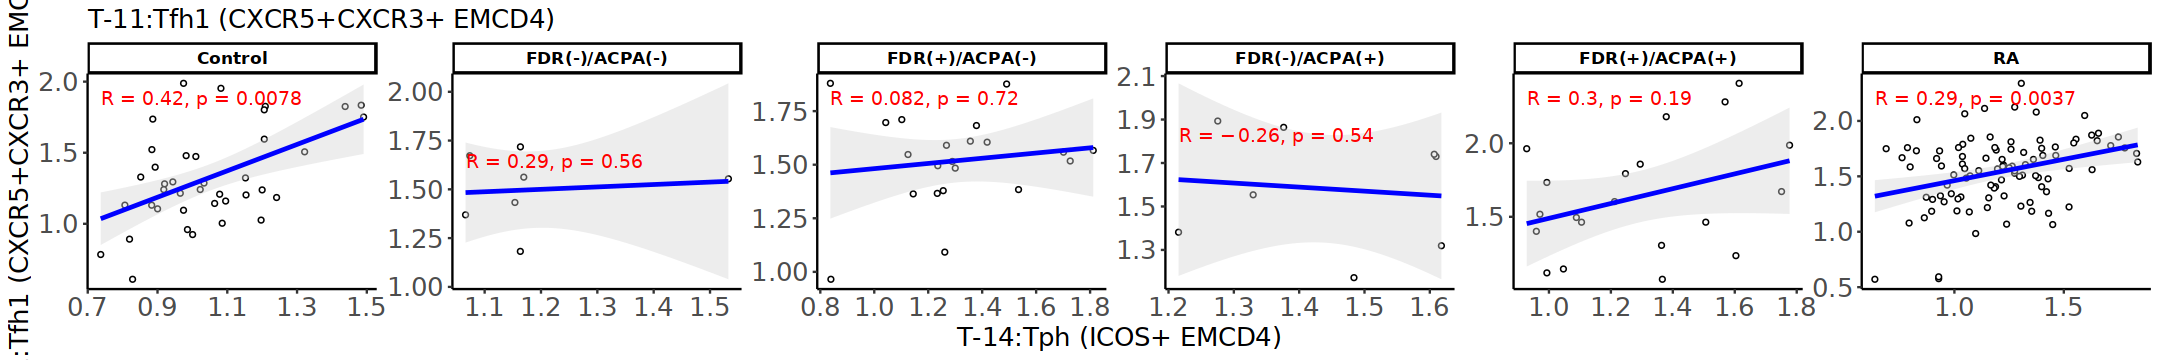

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


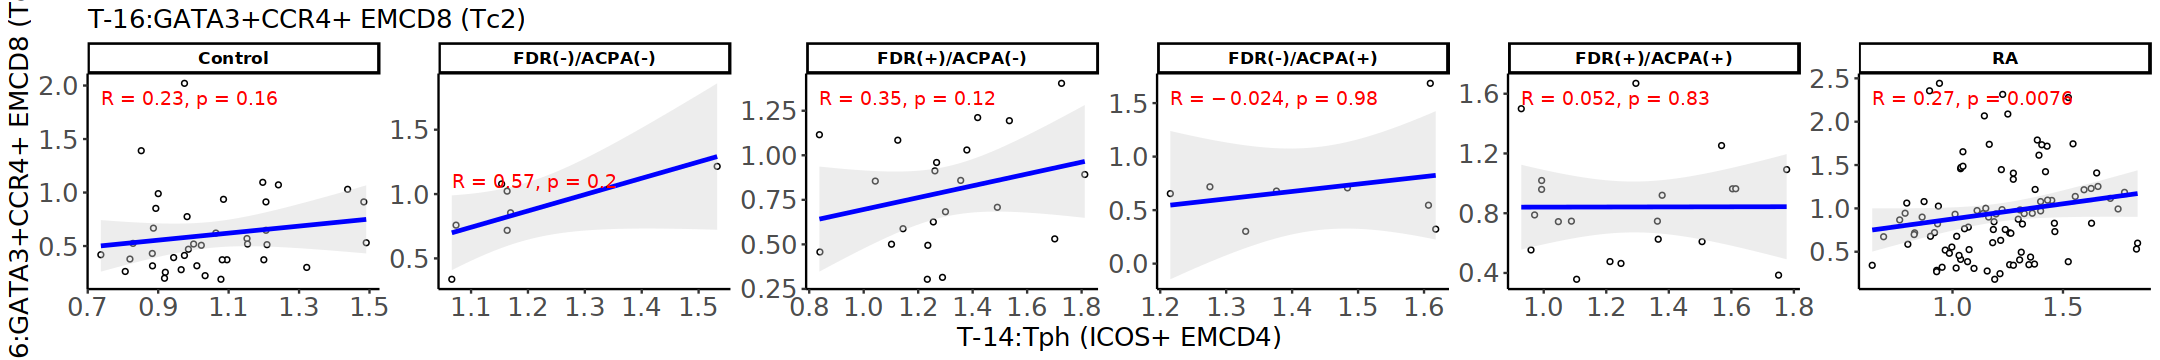

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


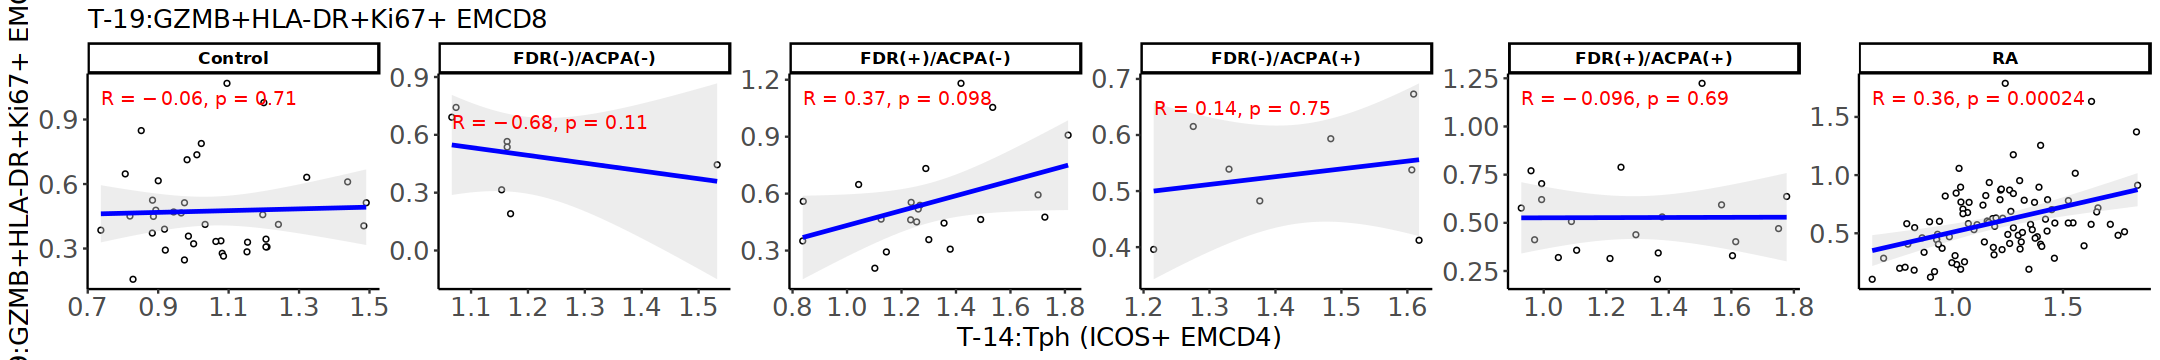

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


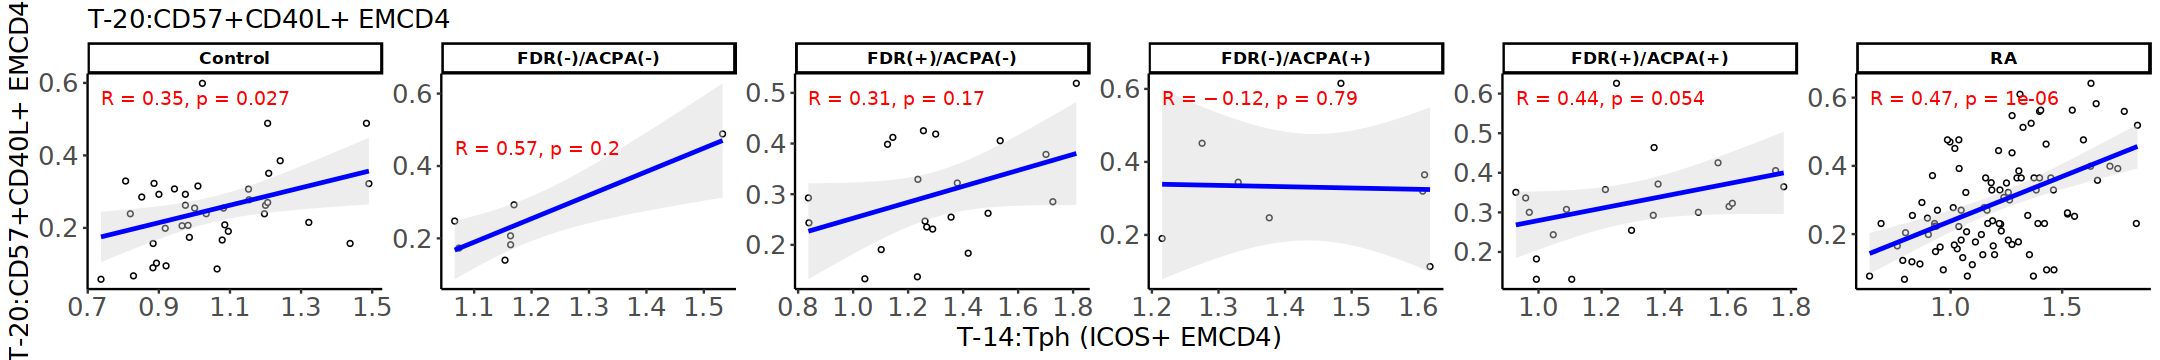

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


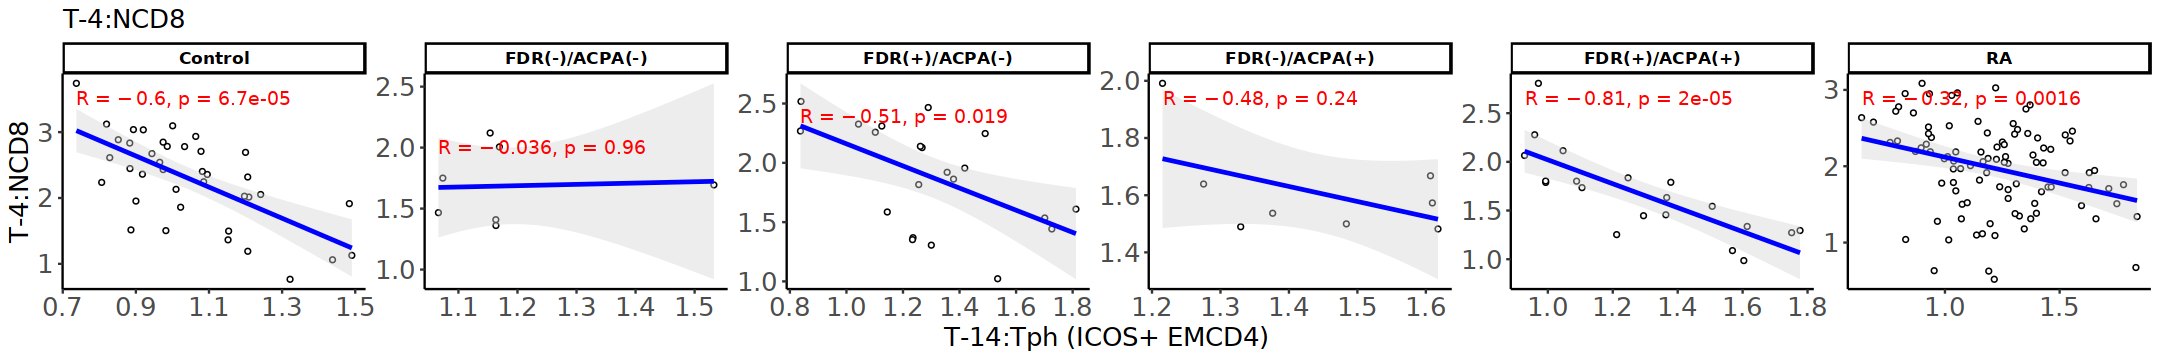

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


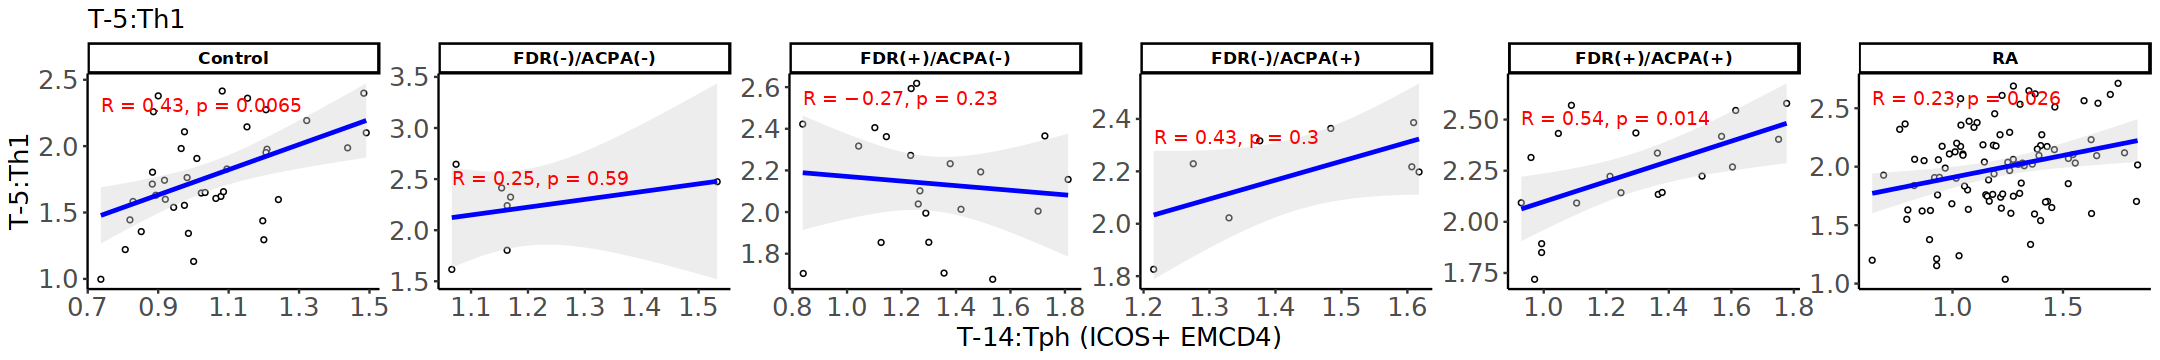

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


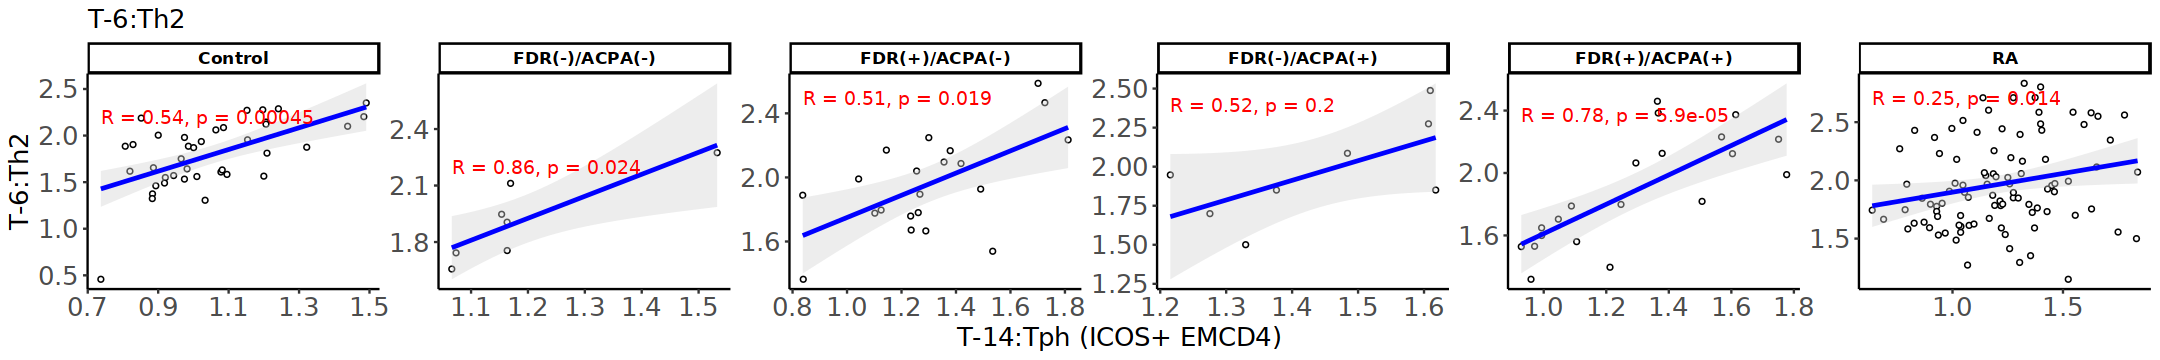

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


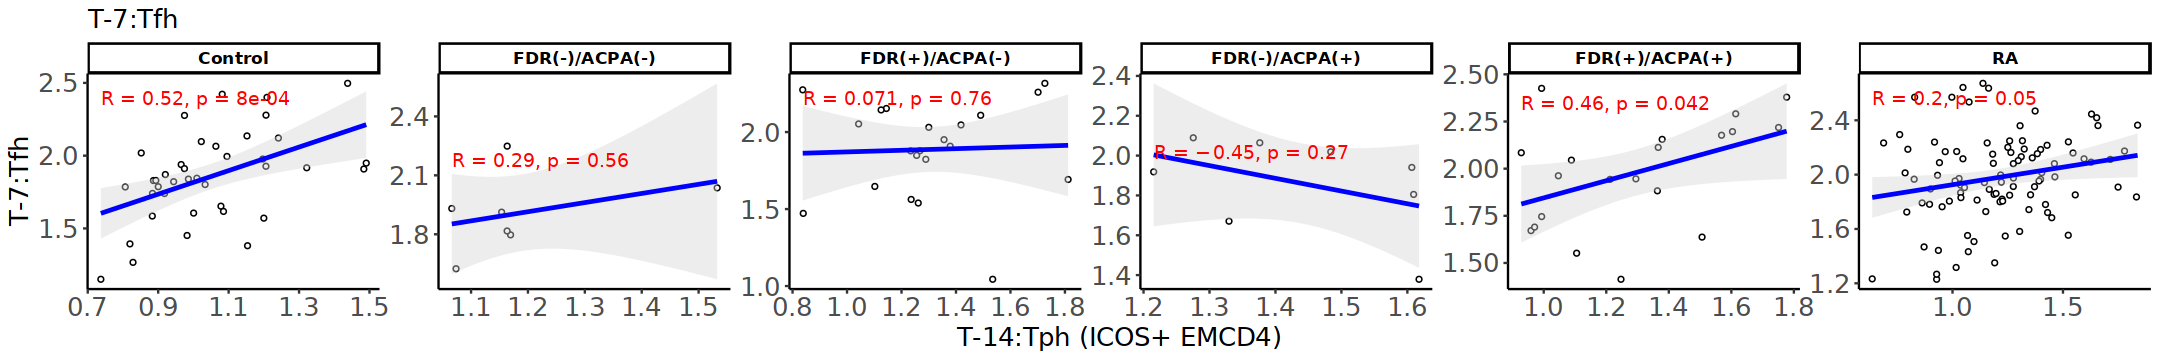

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


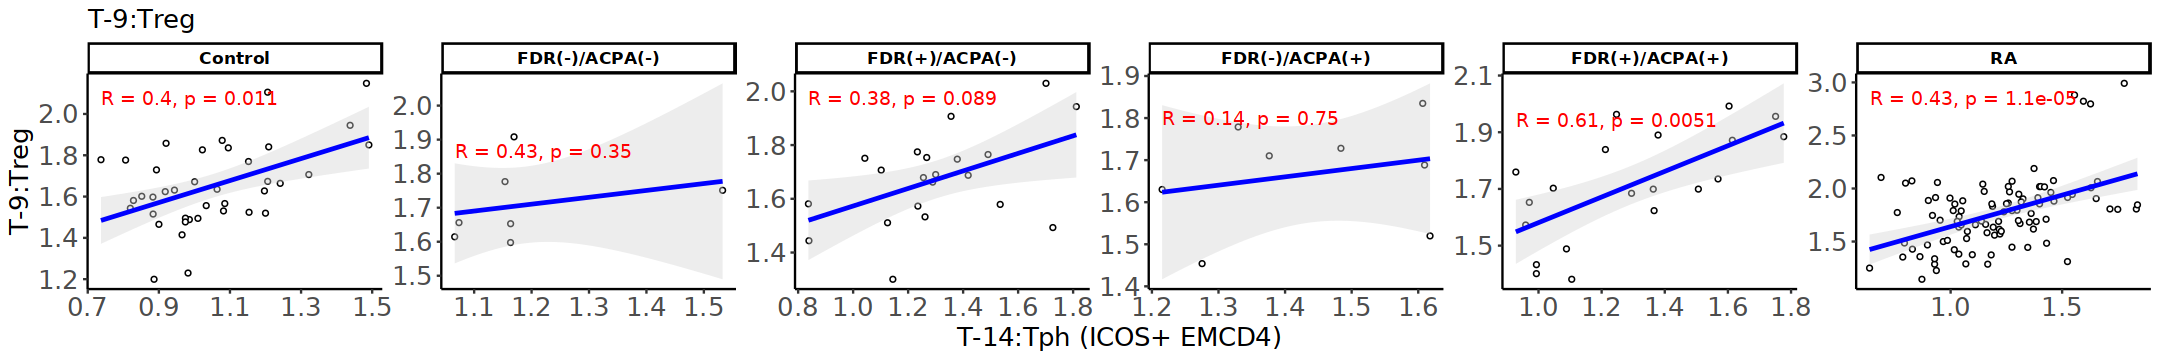

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


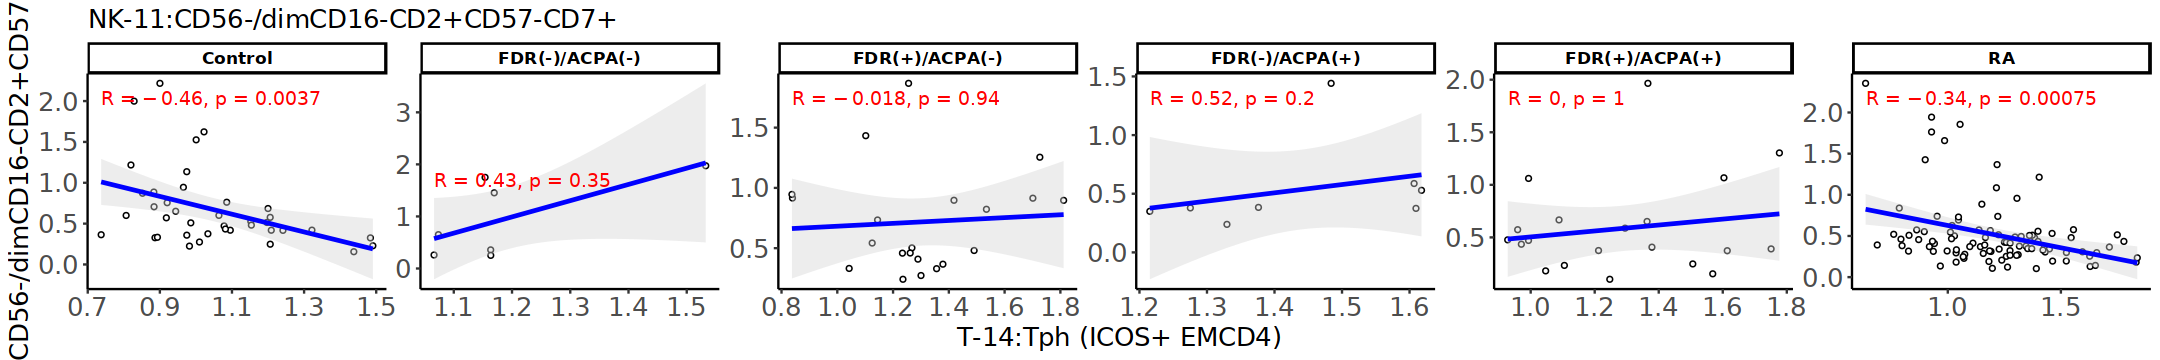

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


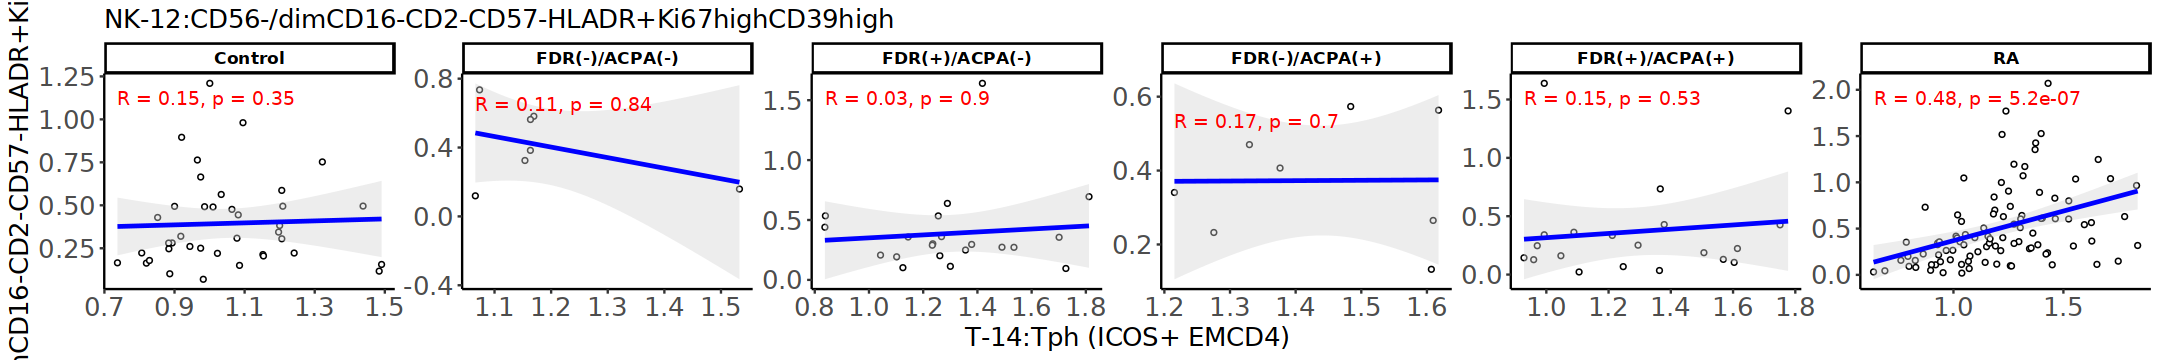

`geom_smooth()` using formula = 'y ~ x'
Warning message in stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", :
“Ignoring unknown parameters: `font.label`”


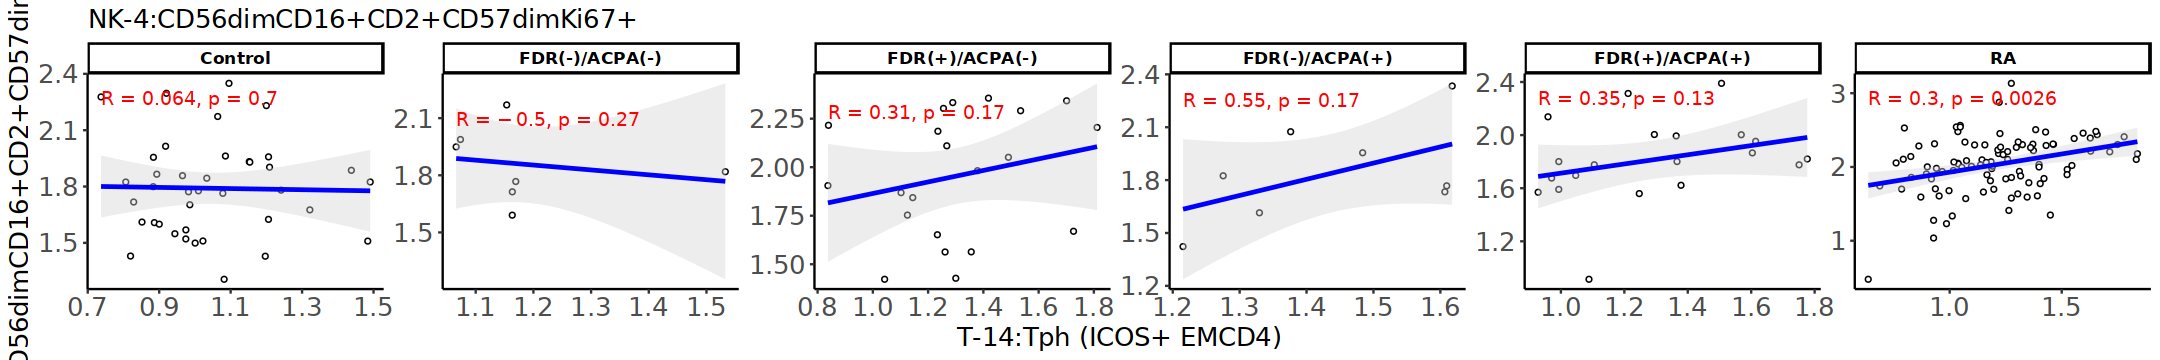

`geom_smooth()` using formula = 'y ~ x'


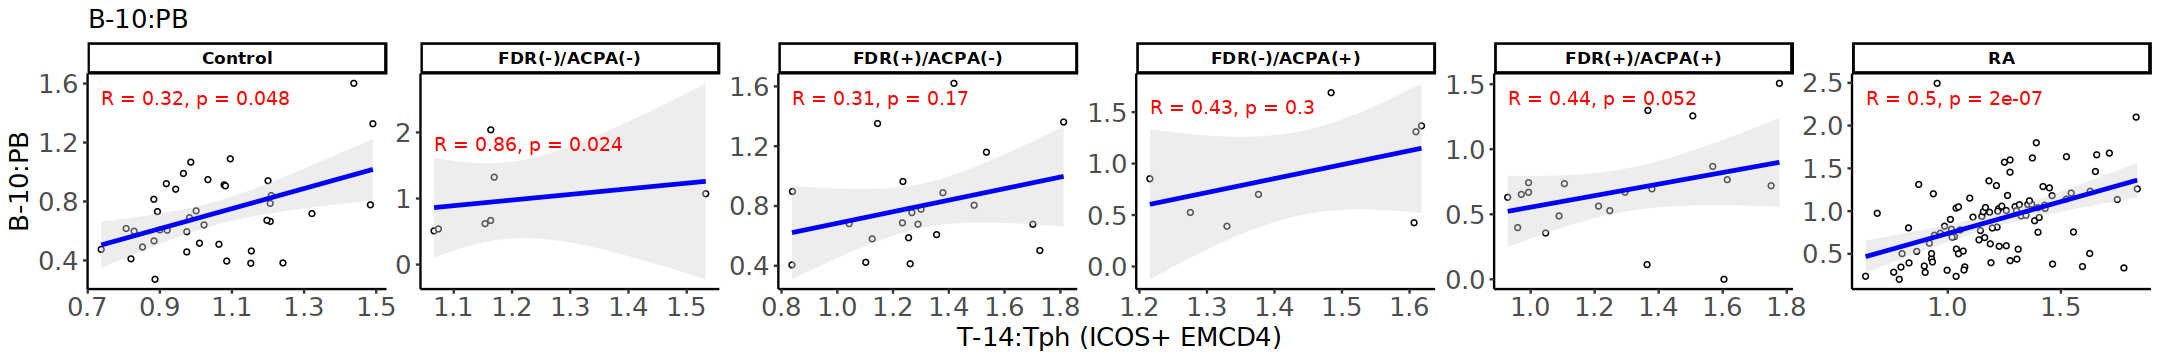

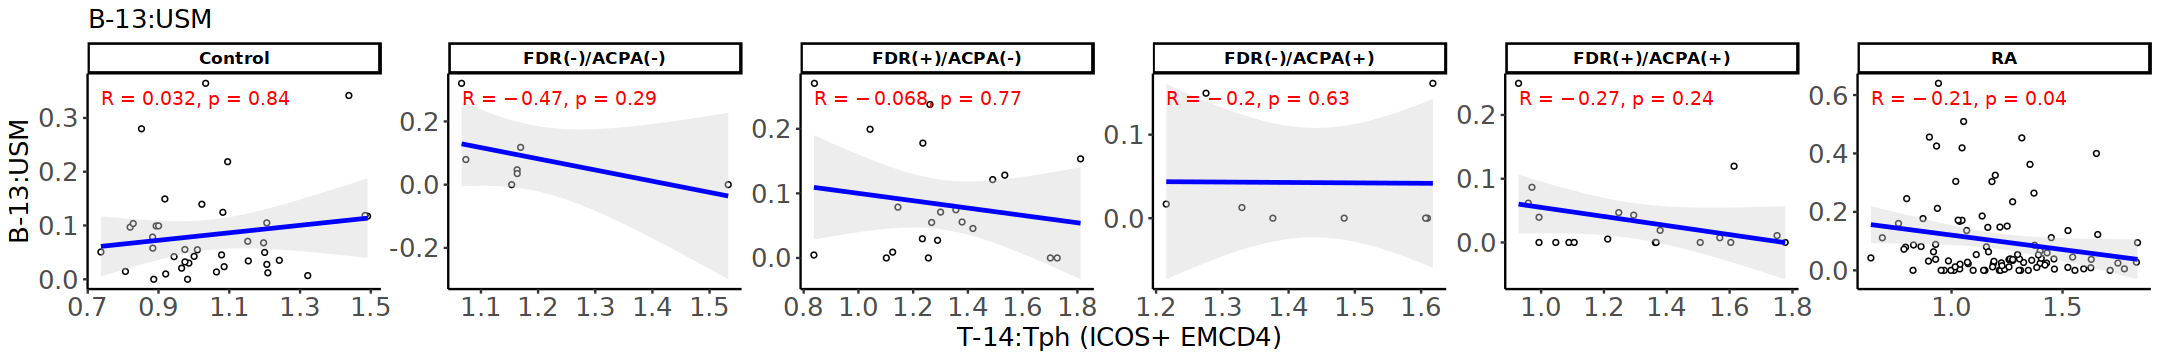

In [9]:

# all samples(V0+V1+V2)

# correlation among proportion of cell subpopulation

p_mat = Hmisc::rcorr(as.matrix(prop_mat),type="spearman")
padj_mat = tabletools::rcorr_padjust(p_mat, method = "BH")
rownames(padj_mat$r) = colnames(padj_mat$r) = rownames(padj_mat$P) = colnames(padj_mat$P) = cluster_df %>%
  dplyr::mutate(cluster_tmp=paste0(ifelse(cell=="M","myeloid",paste0(cell,"_cells")),"_cluster",cluster),
                clu_name = paste0(cell,"-",cluster,":",clu_name)) %>%
  tibble::column_to_rownames("cluster_tmp") %>%
  .[rownames(padj_mat$r),] %>%
  na.omit() %>% .$clu_name

ha = HeatmapAnnotation(cell = stringr::str_split(colnames(prop_mat),pattern="_",simplify=TRUE)[,1] %>% gsub("myeloid","M",.), 
                       col = list(cell = c(
                         "T" = "#4DAF4A",
                         "B" = "#984EA3",
                         "NK" = "#FF7F00",
                         "M" = "#FFFF33")),
                       annotation_name_side = "left")

options(repr.plot.height = 18, repr.plot.width = 18)
ht_list = Heatmap(padj_mat$r, 
                  top_annotation = ha, 
                  col = circlize::colorRamp2(c(-1, 0, 1), c("green", "white", "red")), 
                  show_row_names = TRUE, show_column_names = TRUE, 
                  show_row_dend = FALSE, 
                  show_column_dend = FALSE, 
                  column_title = "pairwise correlation between cell clusters",
                  heatmap_legend_param = list(title = "Correlation"))
draw(ht_list,merge_legends = TRUE, heatmap_legend_side = "bottom")

options(repr.plot.height = 18, repr.plot.width = 18)
ht_list = Heatmap(replace(padj_mat$r, padj_mat$P>0.05, 0), 
                  top_annotation = ha, 
                  col = circlize::colorRamp2(c(-1, 0, 1), c("green", "white", "red")), 
                  show_row_names = TRUE, show_column_names = TRUE, 
                  show_row_dend = FALSE, 
                  show_column_dend = FALSE, 
                  column_title = "pairwise correlation between cell clusters [FDR<0.05]",
                  heatmap_legend_param = list(title = "Correlation"))
draw(ht_list,merge_legends = TRUE, heatmap_legend_side = "bottom")

rownames(padj_mat$r)

df_tmp = prop_mat
colnames(df_tmp) = rownames(padj_mat$r)
x="T-14:Tph (ICOS+ EMCD4)"
# x="T-1:CCR2+ EMCD4"
# x="B-9:CD11c+Tbet+ DN2"
# x="B-6:PAX5dim Naive"
# x="M-0:CD15+ cM"

options(repr.plot.height = 3, repr.plot.width = 3)
for (y in na.omit(names(padj_mat$P[x,][padj_mat$P[x,]<0.05]))){
  
  padj_mat$r[x,y]
  padj_mat$P[x,y]
  
  g=df_tmp %>%
    as.data.frame() %>%
    dplyr::mutate(# AtRisk = ifelse(df_wide$AtRisk == "FDR(-)/ACPA(-)", "Control", as.character(df_wide$AtRisk)),
      time_point = df_wide$time_point,
      AtRisk = factor(df_wide$AtRisk, levels = c("Control","FDR(-)/ACPA(-)","FDR(+)/ACPA(-)","FDR(-)/ACPA(+)","FDR(+)/ACPA(+)","RA"))) %>%
    # dplyr::filter(time_point == "V0") %>%
    ggscatter(., x = x, y = y,
              color = "black", shape = 21, size = 1, # Points color, shape and size
              add = "reg.line",  # Add regressin line
              add.params = list(color = "blue", fill = "lightgray"), # Customize reg. line
              conf.int = TRUE
    ) + 
    # facet_wrap( ~ AtRisk, ncol = 6, scale = "free") + 
    stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", font.label = c(14, "bold", "red"), color = "red") +
    theme_classic() +
    theme(strip.text.x=element_text(size=10, color="black", face="bold"),
          strip.text.y=element_text(size=10, color="black", face="bold"),
          legend.position = "none",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0))  +
    labs(title=y, 
         x = x,
         y = y)
  plot(g)
}

options(repr.plot.height = 3, repr.plot.width = 18)
for (y in na.omit(names(padj_mat$P[x,][padj_mat$P[x,]<0.05]))){
  
  padj_mat$r[x,y]
  padj_mat$P[x,y]
  
  g=df_tmp %>%
    as.data.frame() %>%
    dplyr::mutate(# AtRisk = ifelse(df_wide$AtRisk == "FDR(-)/ACPA(-)", "Control", as.character(df_wide$AtRisk)),
      time_point = df_wide$time_point,
      AtRisk = factor(df_wide$AtRisk, levels = c("Control","FDR(-)/ACPA(-)","FDR(+)/ACPA(-)","FDR(-)/ACPA(+)","FDR(+)/ACPA(+)","RA"))) %>%
    # dplyr::filter(time_point == "V0") %>%
    ggscatter(., x = x, y = y,
              color = "black", shape = 21, size = 1, # Points color, shape and size
              add = "reg.line",  # Add regressin line
              add.params = list(color = "blue", fill = "lightgray"), # Customize reg. line
              conf.int = TRUE
    ) + 
    facet_wrap( ~ AtRisk, ncol = 6, scale = "free") + 
    stat_cor(method = "spearman", label.x.npc = "left", label.y.npc = "top", font.label = c(14, "bold", "red"), color = "red") +
    theme_classic() +
    theme(strip.text.x=element_text(size=10, color="black", face="bold"),
          strip.text.y=element_text(size=10, color="black", face="bold"),
          legend.position = "none",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0))  +
    labs(title=y, 
         x = x,
         y = y)
  plot(g)
}
